In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/jupyter')
sys.path.append('/home/jupyter/checkmate-histo')
from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH) 
MIN_TIL_COUNT = 10

# GRADE_TC_CUTOFF = 0.4  # minimum segment mean grade score to consider in TIL processing 
# GRADE_TC_CUTOFF = 0.  # minimum segment mean grade score to consider in TIL processing 
GRADE_TC_CUTOFF = 0.8  # focusing on high grade foci only 

print('MODIFYING EARLIER TIL CUTOFFS')
TIL_ISO_CUTOFF = 14  # based on none vs any AUROC bootstrap on high grade foci + no hard cases
TIL_HIGH_CUTOFF = 48 # based on not-high vs high AUROC bootstrap on high grade foci + no hard cases
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

EXCLUSION_RATIO_CUTOFF = 1.5  # margin vs center ratio threshold for "exclusion" call
TILES_PER_MM2 = 0.256**-2

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

MODIFYING EARLIER TIL CUTOFFS


In [2]:
from statannotations.Annotator import Annotator
# from statannot import add_stat_annotation
from itertools import combinations, product
from scipy.stats import mannwhitneyu

### Load saved files

In [3]:
mounted_jupyter = '/mnt/disks/image_data/denize_multislide_raw/sgpu2_jupyter_clone_20220609/jupyter/checkmate-histo/consolidated_workflow/multislide_analysis/'
tilewise_nontil_info = pd.read_csv(mounted_jupyter+'denize_multi_passing_twostage_segmentation_tile_level_info.csv', index_col=0)

# rag_inspection NB
dm = pd.read_csv(mounted_jupyter+'denize_multi_case_level_features.csv',index_col=0)
dm['grade_score'] = dm['smoothed_prob_g4_not_g2']

dm['fhs'] = dm['combined_het_score_f_weighted']
dm['ths'] = dm['combined_het_score_total_weighted']
dm['gs'] = dm['grade_score']


## case level aggregations
het_counts = dm.groupby(['case_num'])['any_diff_edge'].sum()
het_counts.name = 'het_count'

het_freq = dm.groupby(['case_num'])['any_diff_edge'].mean()
het_freq.name = 'het_freq'

block_counts = dm.value_counts('case_num')
block_counts.name = 'block_count'

In [4]:
block_counts.mean()

3.857142857142857

In [5]:
block_counts.loc[block_counts >= 3].describe()

count    21.000000
mean      4.571429
std       1.832251
min       3.000000
25%       4.000000
50%       4.000000
75%       5.000000
max      10.000000
Name: block_count, dtype: float64

In [6]:
scattered_results = {}

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


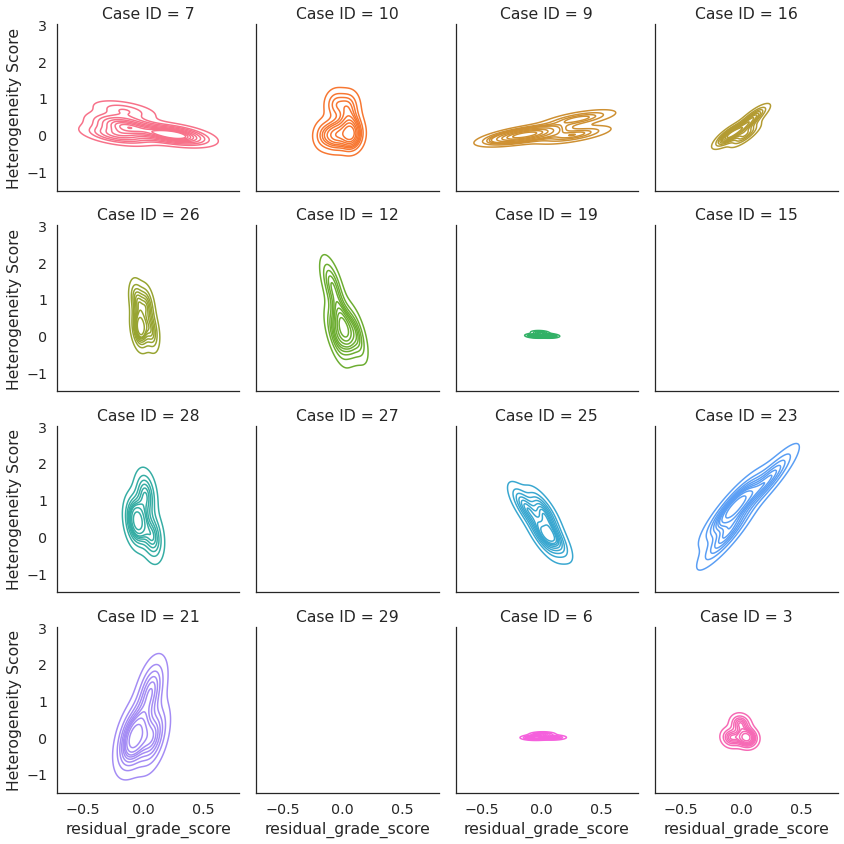

In [7]:
set_rc(12,12,1.3)
MIN_SLIDES = 4
passing_case_nums = get_indices(dm.dropna(subset=['combined_het_score_f_weighted']).value_counts('case_num') >= MIN_SLIDES)

plot_df = dm.loc[passing_case_nums].copy().reset_index()
plot_df['Case ID'] = plot_df['case_num'].astype(str)
plot_df['Grade Score'] = plot_df['grade_score']
plot_df['Heterogeneity Score'] = plot_df['combined_het_score_f_weighted']

g = sns.FacetGrid( data=plot_df,col='Case ID', hue='Case ID',col_wrap=4, height=3)
g.map_dataframe(sns.kdeplot, x='residual_grade_score', y='Heterogeneity Score' )
# plt.suptitle('Grade and Heterogeneity Scores \n Cases with 4+ Blocks',y=1.1)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1+ Het. Block in Case vs. Fully Homogeneous Case: Mann-Whitney-Wilcoxon test two-sided, P_val:7.491e-01 U_stat=5.900e+01


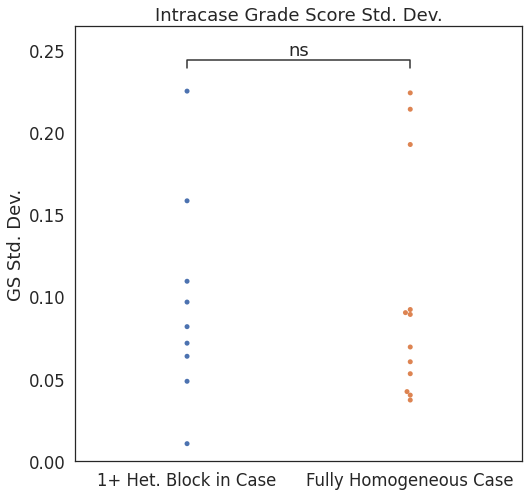

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

at_least_2_het vs. one_het_rest_homog: Mann-Whitney-Wilcoxon test two-sided, P_val:8.148e-01 U_stat=3.900e+01
one_het_rest_homog vs. fully_homogeneous: Mann-Whitney-Wilcoxon test two-sided, P_val:2.141e-01 U_stat=2.400e+01
at_least_2_het vs. fully_homogeneous: Mann-Whitney-Wilcoxon test two-sided, P_val:5.035e-02 U_stat=3.100e+01


Text(0.5, 40.234375, '')

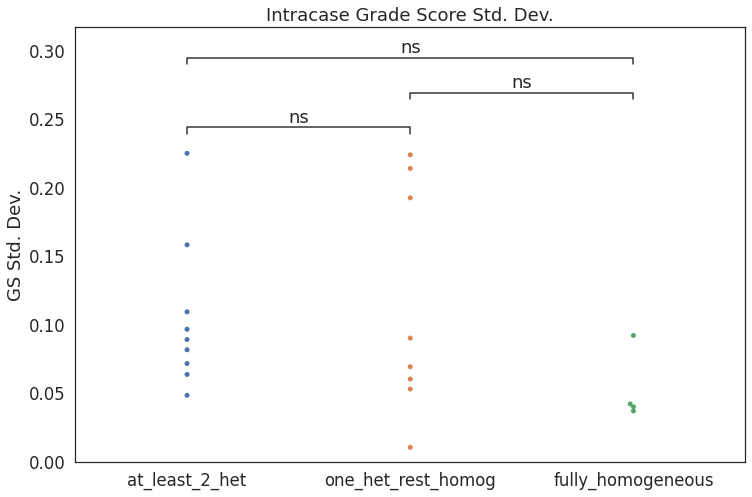

In [8]:
set_rc(12,12,1.)
MIN_SLIDES = 3
col = 'at_least_1_het'
passing_case_nums = get_indices(dm.dropna(subset=['combined_het_score_f_weighted']).value_counts('case_num') >= MIN_SLIDES)

plot_df = dm.loc[passing_case_nums].copy().reset_index()
plot_df.loc[~plot_df[col], 'het_meta_group'] = 'fully_homogeneous'
plot_df.loc[(plot_df['at_least_1_het']) & (~plot_df['at_least_2_het']), 'het_meta_group'] = 'one_het_rest_homog'
plot_df.loc[plot_df['at_least_2_het'], 'het_meta_group'] = 'at_least_2_het'
# plot_df['het_score_group_binary'] = plot_df['het_score_group'].map({'homogeneous':'homogeneous'}).fillna('at_least_one_het')
plot_df['het_score_group_binary'] = plot_df['het_score_group'].map({'homogeneous':'Fully Homogeneous Case'}).fillna('1+ Het. Block in Case')

casewise = plot_df.groupby('case_num')[['ths','fhs','gs']].aggregate(['max','mean','std'])
casewise.columns = ['_'.join(x) for x in casewise.columns]

df = plot_df.reset_index().drop_duplicates('case_num')
df = df.set_index('case_num')
df = df.join(casewise)

for series in [het_counts, het_freq, block_counts]:
    df = df.join(series)

plot_kws = {
    'order':None,
    'x':'het_score_group_binary',
    'y':'gs_std',
    'hue':None,
    'hue_order':None,
    'data':df,
}

set_rc(8,8,1.5)
g = sns.swarmplot(**plot_kws)
# a = list((product( df[plot_kws['x']].unique(), df[plot_kws['hue']].unique(),)))
# pairs = list(combinations(a, 2))
pairs = list(combinations(df[plot_kws['x']].unique(),2))

annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()
plt.title('Intracase Grade Score Std. Dev.')
plt.ylabel('GS Std. Dev.')
plt.xlabel('')
plt.show()

plot_kws = {
    'order':None,
    'x':'het_meta_group',
    'y':'gs_std',
    'hue':None,
    'hue_order':None,
    'data':df,
}

set_rc(12,8,1.5)
g = sns.swarmplot(**plot_kws)
# a = list((product( df[plot_kws['x']].unique(), df[plot_kws['hue']].unique(),)))
# pairs = list(combinations(a, 2))
pairs = list(combinations(df[plot_kws['x']].unique(),2))

annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()
plt.title('Intracase Grade Score Std. Dev.')
plt.ylabel('GS Std. Dev.')
plt.xlabel('')

In [9]:
dm['het_score_group']

case_num
1          homogeneous
1          homogeneous
10     lower_het_score
10         homogeneous
10         homogeneous
            ...       
9          homogeneous
9          homogeneous
9     higher_het_score
9          homogeneous
9          homogeneous
Name: het_score_group, Length: 108, dtype: object

In [10]:
plot_df['het_score_group_binary'].value_counts()

Fully Homogeneous Case    59
1+ Het. Block in Case     37
Name: het_score_group_binary, dtype: int64

In [11]:
plot_df['het_meta_group'].value_counts()

at_least_2_het        49
one_het_rest_homog    32
fully_homogeneous     15
Name: het_meta_group, dtype: int64

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

at_least_2_het vs. one_het_rest_homog: Mann-Whitney-Wilcoxon test two-sided, P_val:8.204e-01 U_stat=8.080e+02
one_het_rest_homog vs. fully_homogeneous: Mann-Whitney-Wilcoxon test two-sided, P_val:6.896e-01 U_stat=2.220e+02
at_least_2_het vs. fully_homogeneous: Mann-Whitney-Wilcoxon test two-sided, P_val:8.866e-01 U_stat=3.580e+02


(<AxesSubplot:xlabel='het_meta_group', ylabel='residual_grade_score'>,
  <statannotations.Annotation.Annotation at 0x7f5da7530820>])

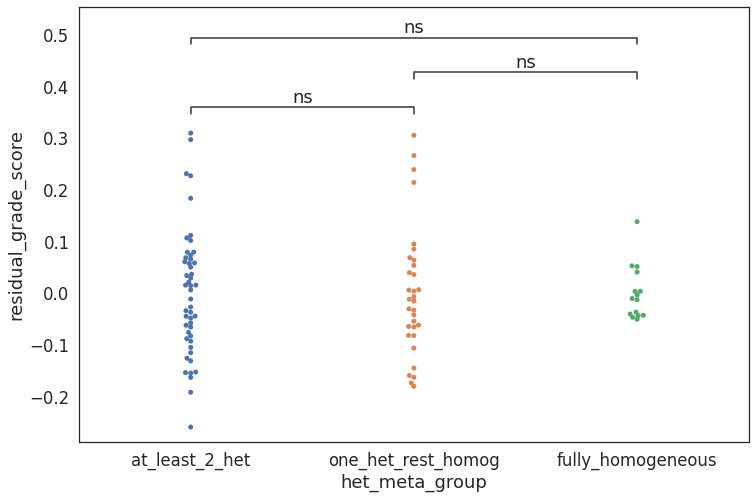

In [12]:
plot_kws = {
    'order':None,
    'x':'het_meta_group',
    'y':'residual_grade_score',
    'hue':None,
    'hue_order':None,
    'data':plot_df,
}

set_rc(12,8,1.5)
g = sns.swarmplot(**plot_kws)
# a = list((product( df[plot_kws['x']].unique(), df[plot_kws['hue']].unique(),)))
# pairs = list(combinations(a, 2))
pairs = list(combinations(df[plot_kws['x']].unique(),2))

annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()
# plt.title('Intracase Grade Score Std. Dev.')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1+ Het. Block in Case vs. Fully Homogeneous Case: Mann-Whitney-Wilcoxon test two-sided, P_val:8.448e-01 U_stat=1.065e+03


(<AxesSubplot:xlabel='het_score_group_binary', ylabel='residual_grade_score'>,
 [<statannotations.Annotation.Annotation at 0x7f5da746cfd0>])

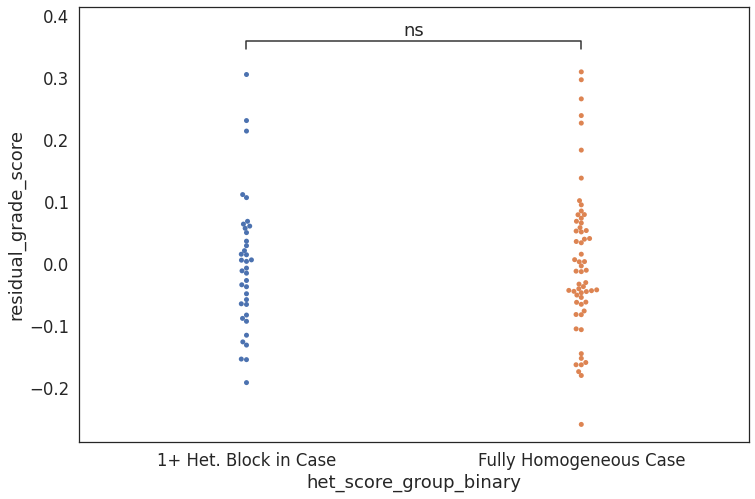

In [13]:
plot_kws = {
    'order':None,
    'x':'het_score_group_binary',
    'y':'residual_grade_score',
    'hue':None,
    'hue_order':None,
    'data':plot_df,
}

set_rc(12,8,1.5)
g = sns.swarmplot(**plot_kws)
# a = list((product( df[plot_kws['x']].unique(), df[plot_kws['hue']].unique(),)))
# pairs = list(combinations(a, 2))
pairs = list(combinations(df[plot_kws['x']].unique(),2))

annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()
# plt.title('Intracase Grade Score Std. Dev.')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1+ Het. Block in Case vs. Fully Homogeneous Case: Mann-Whitney-Wilcoxon test two-sided, P_val:5.349e-01 U_stat=1.009e+03


(<AxesSubplot:xlabel='het_score_group_binary', ylabel='residual_grade_score_max'>,
 [<statannotations.Annotation.Annotation at 0x7f5da73f45e0>])

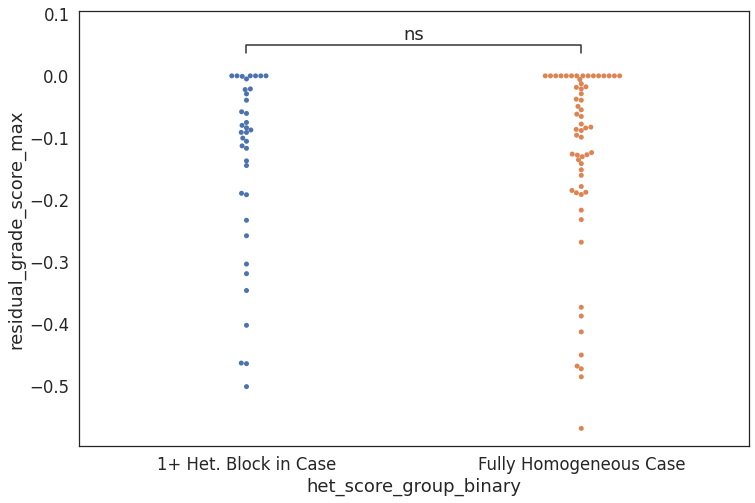

In [14]:
plot_kws = {
    'order':None,
    'x':'het_score_group_binary',
    'y':'residual_grade_score_max',
    'hue':None,
    'hue_order':None,
    'data':plot_df,
}

set_rc(12,8,1.5)
g = sns.swarmplot(**plot_kws)
# a = list((product( df[plot_kws['x']].unique(), df[plot_kws['hue']].unique(),)))
# pairs = list(combinations(a, 2))
pairs = list(combinations(df[plot_kws['x']].unique(),2))

annotator = Annotator(g, pairs, **plot_kws)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_and_annotate()
# plt.title('Intracase Grade Score Std. Dev.')

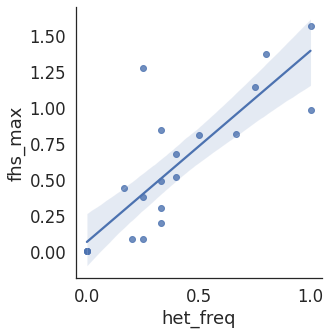

In [15]:
sns.lmplot(x='het_freq', y='fhs_max', data=df)

### GS/HS Range Properties

In [16]:
def get_range(series):
    return series.max() - series.min()

gs_ranges = dm.groupby('case_num')['gs'].apply(get_range)
gs_ranges.name = 'gs_range'

fhs_ranges = dm.groupby('case_num')['fhs'].apply(get_range)
fhs_ranges.name = 'fhs_range'


range_df = pd.DataFrame({'fhs_range':fhs_ranges, 
                         'fhs_mean':dm.groupby('case_num')['fhs'].mean(), 
                         'gs_range':gs_ranges
                        })
range_df = range_df.join(block_counts)
range_df = range_df.loc[range_df['block_count'] >= 2]

range_df['gs_range_flag'] = range_df['gs_range'] > NODE_DIFF_CUTOFF
range_df['hs_range_flag'] = range_df['fhs_range'] > 0 

crit = range_df['gs_range_flag'] & range_df['hs_range_flag']
range_df.loc[crit, 'joint_class'] = 'dual_heterogeneity'

crit = range_df['gs_range_flag'] & ~range_df['hs_range_flag']
range_df.loc[crit, 'joint_class'] = 'gs_het_only'

crit = ~range_df['gs_range_flag'] & range_df['hs_range_flag']
range_df.loc[crit, 'joint_class'] = 'hs_het_only'

crit = ~range_df['gs_range_flag'] & ~range_df['hs_range_flag']
range_df.loc[crit, 'joint_class'] = 'dual_homogeneity'



# for cutoff in [0.05, 0.1, 0.15, 0.2, 0.3]:
#     range_df['gs_range_flag'] = range_df['gs_range'] > cutoff
#     range_df['hs_range_flag'] = range_df['fhs_range'] > 0 

#     crit = range_df['gs_range_flag'] & range_df['hs_range_flag']
#     range_df.loc[crit, 'joint_class'] = 'dual_heterogeneity'

#     crit = range_df['gs_range_flag'] & ~range_df['hs_range_flag']
#     range_df.loc[crit, 'joint_class'] = 'gs_het_only'

#     crit = ~range_df['gs_range_flag'] & range_df['hs_range_flag']
#     range_df.loc[crit, 'joint_class'] = 'hs_het_only'

#     crit = ~range_df['gs_range_flag'] & ~range_df['hs_range_flag']
#     range_df.loc[crit, 'joint_class'] = 'dual_homogeneity'
#     print(cutoff, '\n',range_df.joint_class.value_counts())

In [17]:
df = merge_nonoverlapping(df, range_df)

In [18]:
plot_cols = ['fhs_mean','fhs_std','gs_mean','gs_std','gs_range','het_freq']

In [19]:
het_score_stats = df.reset_index().melt(
    id_vars=['case_num','het_count','het_freq','block_count'], 
    value_vars=plot_cols, 
    value_name='het_score_stat',
)


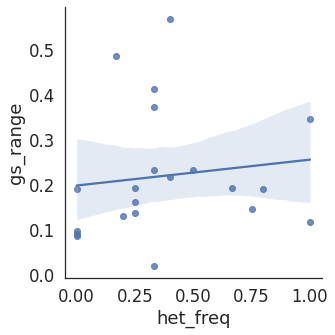

In [20]:
sns.lmplot(x='het_freq', y='gs_range', data=df)

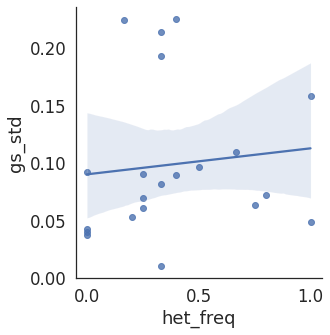

In [21]:
sns.lmplot(x='het_freq', y='gs_std', data=df)

In [22]:
df['gs_std'].shape

(21,)

In [23]:
# set_rc(8,8, 1.)
# sns.pairplot(df[plot_cols], kind='reg', diag_kws={'bins':10}, size=3.5)

<AxesSubplot:>

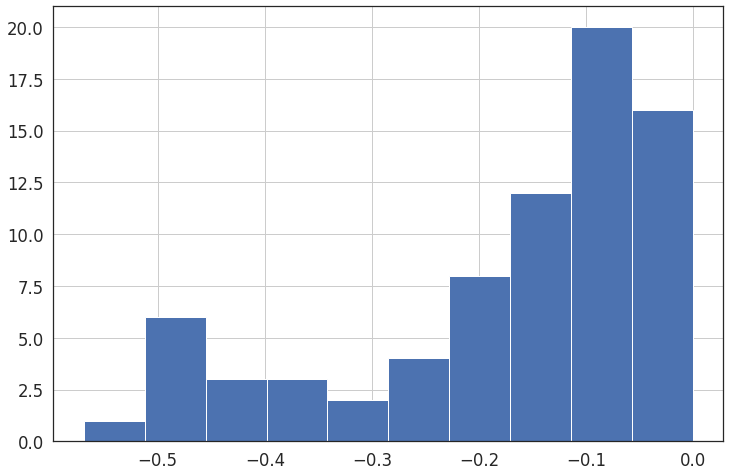

In [24]:
plot_df.loc[plot_df['residual_grade_score_max'] != 0, 'residual_grade_score_max'].hist()

In [25]:
temp = df.copy()
# temp = temp.loc[temp['block_count'] <= 5]

i = temp.loc[temp['het_meta_group'] == 'at_least_2_het','gs_range']
j = temp.loc[temp['het_meta_group'] != 'at_least_2_het','gs_range']
print(i.shape, j.shape)

print(mannwhitneyu(i,j))

i = temp.loc[temp['het_meta_group'] == 'at_least_2_het','gs_std']
j = temp.loc[temp['het_meta_group'] != 'at_least_2_het','gs_std']
print(i.shape, j.shape)

mannwhitneyu(i,j)

(9,) (12,)
MannwhitneyuResult(statistic=75.0, pvalue=0.14515183740205176)
(9,) (12,)


MannwhitneyuResult(statistic=70.0, pvalue=0.2706629953488259)

In [26]:
temp = df.copy()
temp = temp.loc[temp['block_count'] <= 5]

i = temp.loc[temp['het_meta_group'] == 'at_least_2_het','gs_range']
j = temp.loc[temp['het_meta_group'] != 'at_least_2_het','gs_range']
print(i.shape, j.shape)

print(mannwhitneyu(i,j))

i = temp.loc[temp['het_meta_group'] == 'at_least_2_het','gs_std']
j = temp.loc[temp['het_meta_group'] != 'at_least_2_het','gs_std']
print(i.shape, j.shape)

mannwhitneyu(i,j)

(7,) (11,)
MannwhitneyuResult(statistic=54.0, pvalue=0.17911010558069382)
(7,) (11,)


MannwhitneyuResult(statistic=51.0, pvalue=0.2854449472096531)

In [27]:
MIN_SLIDES = 3
passing_case_nums = get_indices(dm.dropna(subset=['combined_het_score_f_weighted']).value_counts('case_num') >= MIN_SLIDES)

nonhomog = dm.loc[passing_case_nums].copy().reset_index()
nonhomog = nonhomog.loc[nonhomog['any_diff_edge']]

nonhomog = nonhomog.set_index(['case_num']).join(het_freq)
nonhomog = nonhomog.groupby('case_num').aggregate(['mean','max','min','std'])
nonhomog.columns = ['_'.join(x) for x in nonhomog.columns]
nonhomog = nonhomog.join(block_counts)

In [28]:
MIN_SLIDES

3

In [29]:
z = dm.loc[passing_case_nums]
z.loc[z['any_diff_edge']]['fhs'].describe()

count    37.000000
mean      0.541232
std       0.389256
min       0.067300
25%       0.213721
50%       0.438426
75%       0.812541
max       1.559378
Name: fhs, dtype: float64

In [30]:
z = dm.loc[passing_case_nums]
z.loc[z['any_diff_edge']]['ths'].describe()

count    37.000000
mean      1.096105
std       0.519546
min       0.108467
25%       0.906221
50%       0.987123
75%       1.291870
max       2.262778
Name: ths, dtype: float64

In [31]:
score_avgs = {
    'f': z.loc[z['any_diff_edge']]['fhs'].mean(),
    't': z.loc[z['any_diff_edge']]['ths'].mean(),    
}

In [32]:
score_avgs_full = {
    'f': z['fhs'].mean(),
    't': z['ths'].mean(),    
}

<AxesSubplot:>

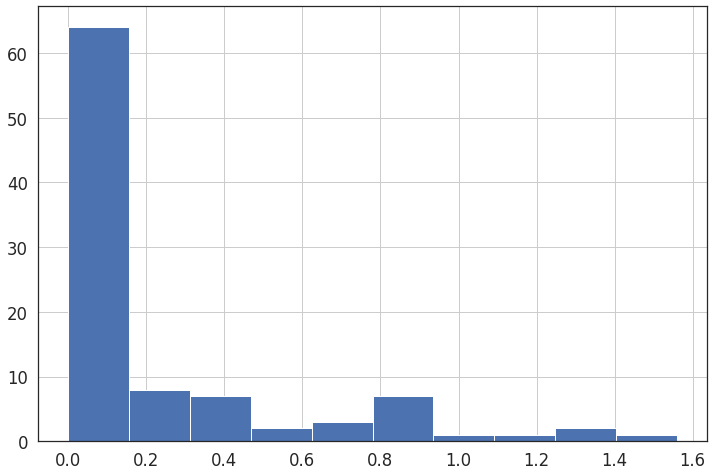

In [33]:
z['fhs'].hist()

<AxesSubplot:xlabel='fhs', ylabel='Count'>

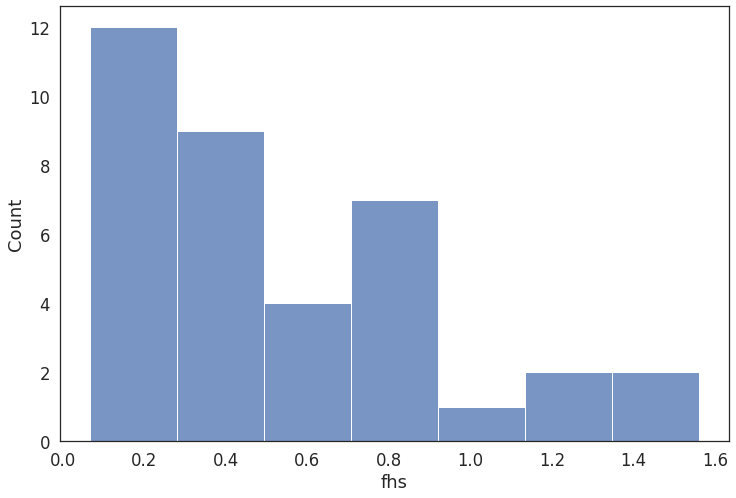

In [34]:
sns.histplot(x='fhs', data=z.loc[z['any_diff_edge']].reset_index())

In [35]:
from scipy.stats import expon

In [36]:
lmbda = z.loc[z['any_diff_edge']]['fhs'].mean()
lmbda

0.5412321377338308

In [37]:
expon(scale=lmbda).mean()

0.5412321377338308

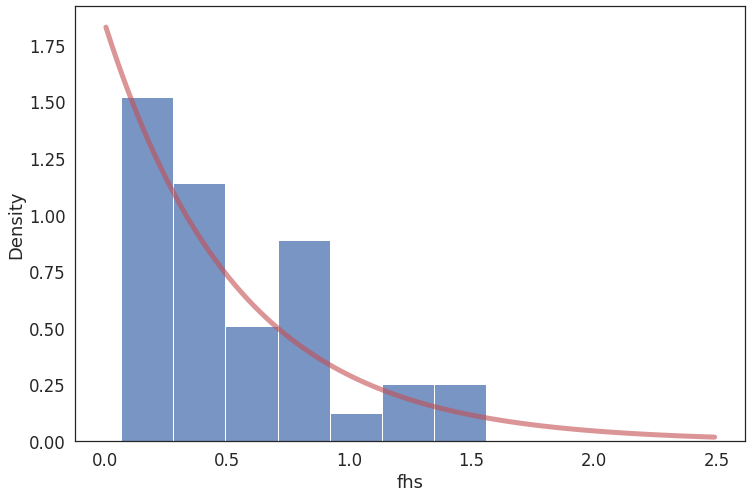

In [38]:
sns.histplot(x='fhs', data=z.loc[z['any_diff_edge']].reset_index(), stat='density')
ax = plt.gca()
x = np.linspace(expon.ppf(0.01, scale=lmbda),
                expon.ppf(0.99, scale=lmbda), 100)
ax.plot(x, expon.pdf(x, scale=lmbda),
       'r-', lw=5, alpha=0.6, label='expon pdf')

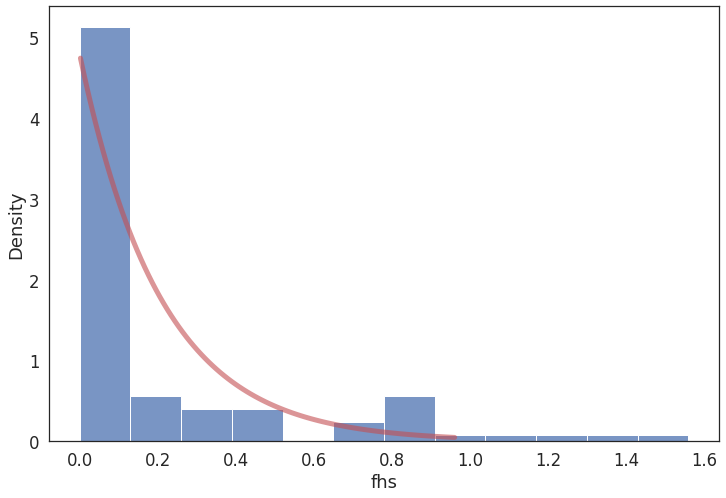

In [39]:
sns.histplot(x='fhs', data=z.reset_index(), stat='density')
lmbda = z['fhs'].mean()

ax = plt.gca()
x = np.linspace(expon.ppf(0.01, scale=lmbda),
                expon.ppf(0.99, scale=lmbda), 100)
ax.plot(x, expon.pdf(x, scale=lmbda),
       'r-', lw=5, alpha=0.6, label='expon pdf')

<AxesSubplot:>

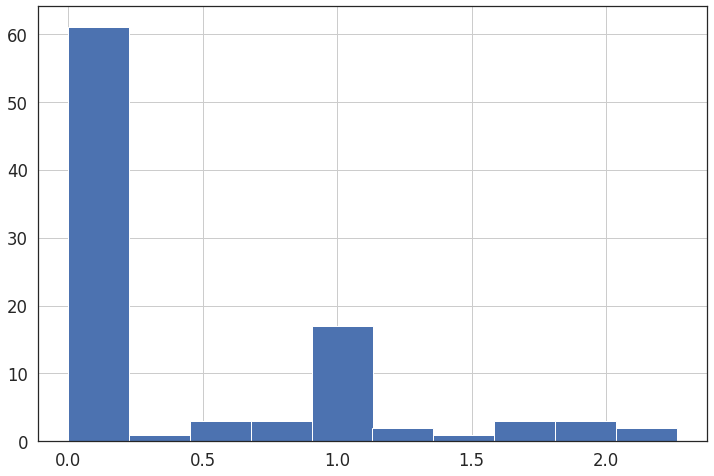

In [40]:
z['ths'].hist()

In [41]:
score_avgs_full

{'f': 0.2085998864182473, 't': 0.422457244320196}

In [42]:
from scipy.stats import pearsonr

0.7373383101356706 0.0007313338566483678


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


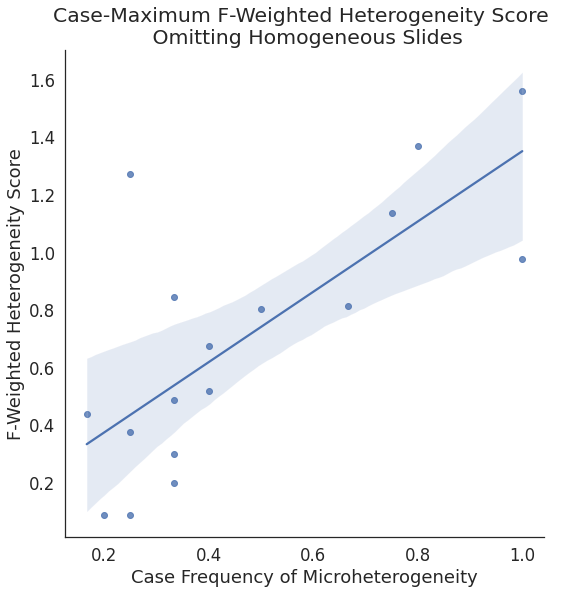

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


0.7373383101356706 0.0007313338566483678


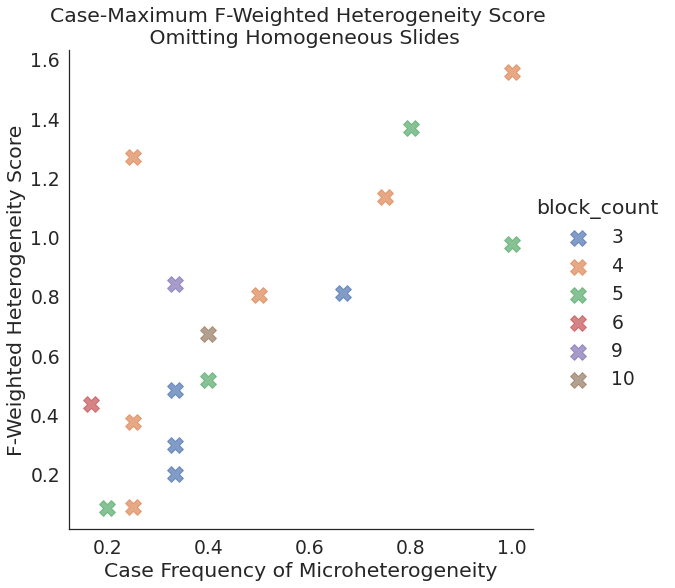

0.30200131658565577 0.2387571412385807


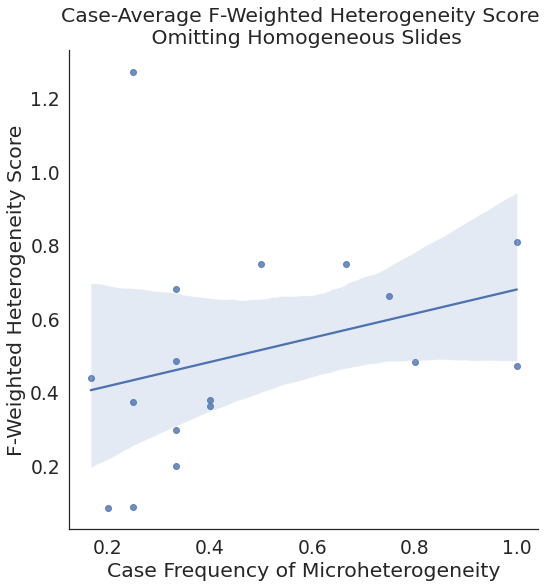

0.30200131658565577 0.2387571412385807


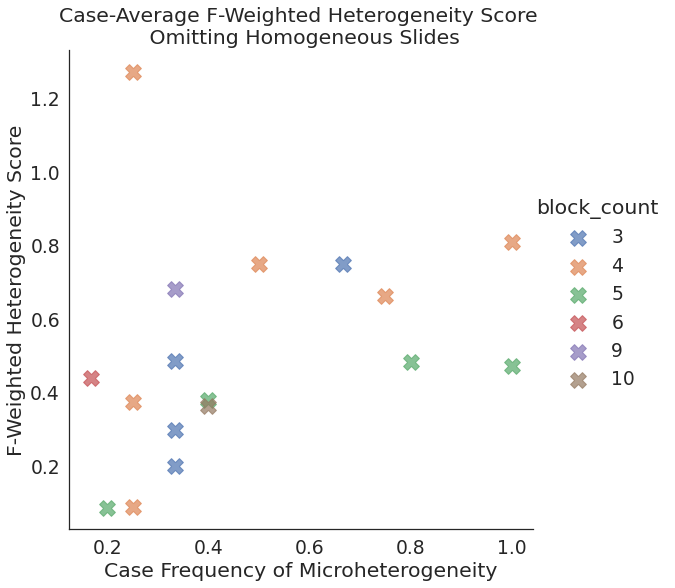

0.33503309718372176 0.18866514885512004


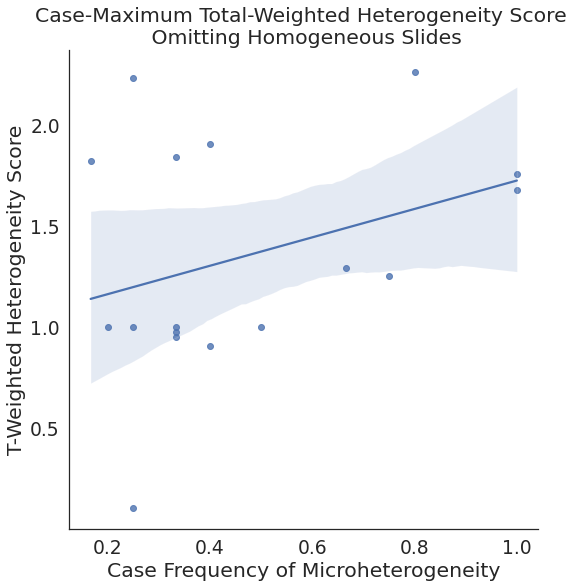

0.33503309718372176 0.18866514885512004


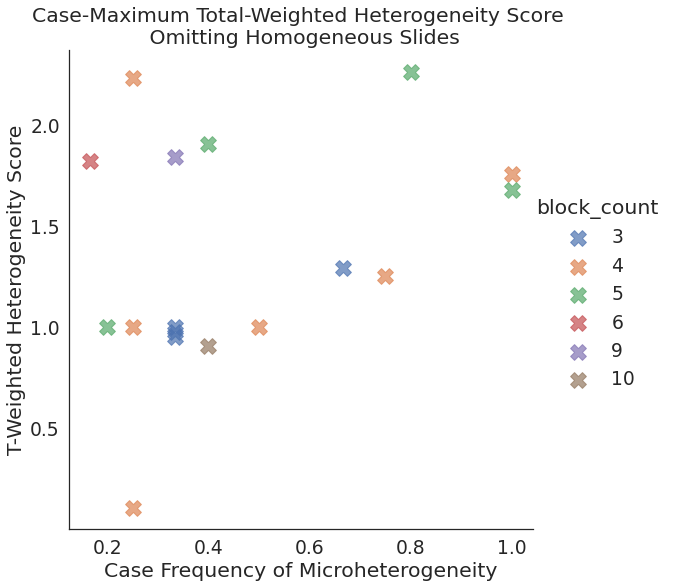

-0.08600483900225388 0.7427563115696139


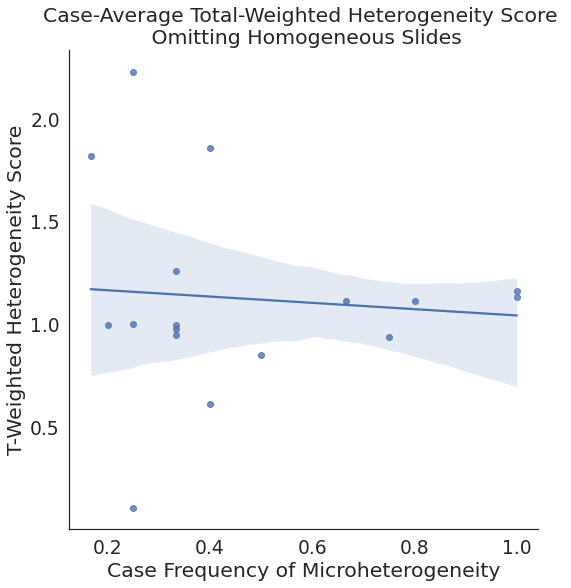

-0.08600483900225388 0.7427563115696139


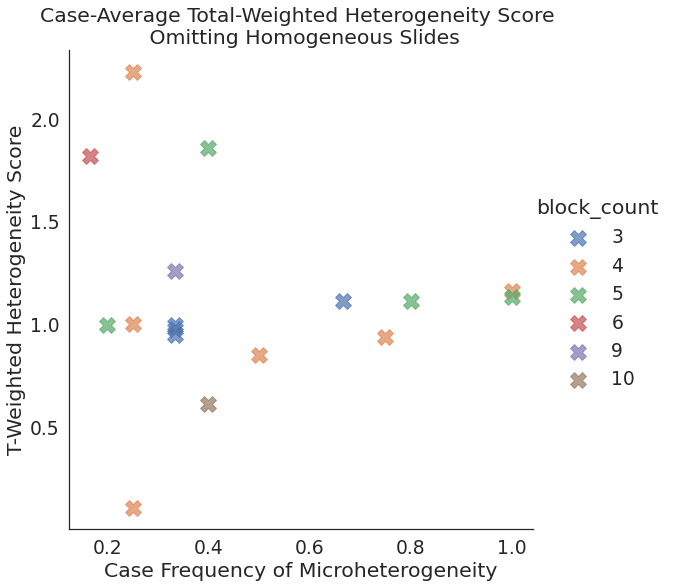

In [43]:
for prefix in ['f','t']:
    for agg_type in ['max','mean']:
        for plot_style in ['reg','hue_mark']:
            rho, pval = pearsonr(nonhomog['het_freq_mean'], nonhomog[f'{prefix}hs_{agg_type}'])
            print(rho, pval)
            if plot_style == 'reg':
                sns.lmplot(x=f'het_freq_mean', y=f'{prefix}hs_{agg_type}', data=nonhomog, height=8)
                # plt.axhline(score_avgs[prefix], c='r', ls='--')
            else:
                sns.lmplot(x='het_freq_mean', y=f'{prefix}hs_{agg_type}', hue='block_count', markers='X', fit_reg=False, data=nonhomog, height=8, scatter_kws={'s':250, 'alpha':.7})

            set_rc(8,8,1.7)
            
            if agg_type == 'mean':
                agg_str = 'Average'
            if agg_type == 'max':
                agg_str = 'Maximum'
                
            prefix_str = 'Total' if prefix == 't' else 'F'
            plt.title(f'Case-{agg_str} {prefix_str}-Weighted Heterogeneity Score \n Omitting Homogeneous Slides')
            plt.ylabel(f'{prefix.upper()}-Weighted Heterogeneity Score')
            plt.xlabel('Case Frequency of Microheterogeneity')
            plt.savefig(f'./multislide_figures/omitting_homog_{plot_style}_{prefix}hs_{agg_type}_{MIN_SLIDES}plus.png', bbox_inches='tight')
            plt.show()
            
            pval_str = '[supp] [pearsonrho, pval] ' + ''f'omitting_homog_{plot_style}_case_mh_freq_vs_{prefix}hs_{agg_type}_{MIN_SLIDES}plus'
            scattered_results[pval_str] = (rho, pval)

In [44]:
# data = full
# for prefix in ['f','t']:
#     for agg_type in ['max','mean']:
#         for plot_style in ['reg','hue_mark']:
#             rho, pval = pearsonr(data['het_freq_mean'], data[f'{prefix}hs_{agg_type}'])
#             print(rho, pval)
#             if plot_style == 'reg':
#                 sns.lmplot(y=f'het_freq_mean', x=f'{prefix}hs_{agg_type}', data=data, height=8)
#                 # plt.axhline(score_avgs[prefix], c='r', ls='--')
#             else:
#                 sns.lmplot(y='het_freq_mean', x=f'{prefix}hs_{agg_type}', hue='block_count', markers='X', fit_reg=False, data=data, height=8, scatter_kws={'s':250, 'alpha':.7})

#             set_rc(8,8,1.7)
            
#             if agg_type == 'mean':
#                 agg_str = 'Average'
#             if agg_type == 'max':
#                 agg_str = 'Maximum'
                
#             prefix_str = 'Total' if prefix == 't' else 'F'
#             plt.title(f'Case-{agg_str} {prefix_str}-Weighted Heterogeneity Score \n ')
#             plt.xlabel(f'{agg_type.title()}. {prefix.upper()}-Weighted Heterogeneity Score')
#             plt.ylabel('Case Frequency of Microheterogeneity')
#             # plt.savefig(f'./multislide_figures/omitting_homog_{plot_style}_{prefix}hs_{agg_type}_{MIN_SLIDES}plus.png', bbox_inches='tight')
#             plt.show()
            
#             # pval_str = '[supp] [pearsonrho, pval] ' + ''f'omitting_homog_{plot_style}_case_mh_freq_vs_{prefix}hs_{agg_type}_{MIN_SLIDES}plus'
#             scattered_results[pval_str] = (rho, pval)

0.0811412659109548 0.7568789996144967


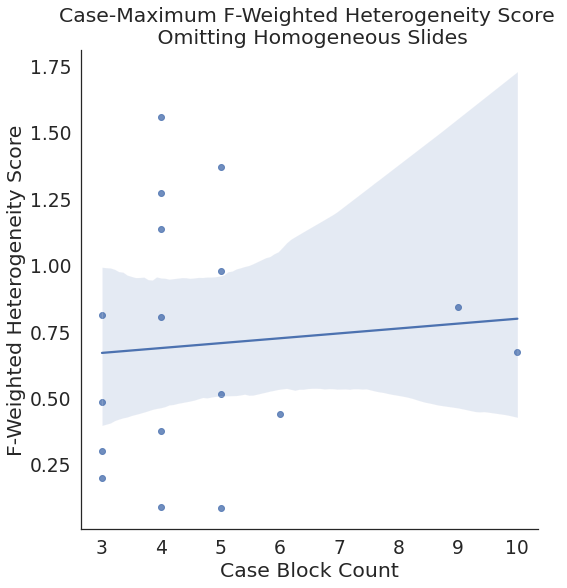

-0.045385892664708216 0.8626787835727205


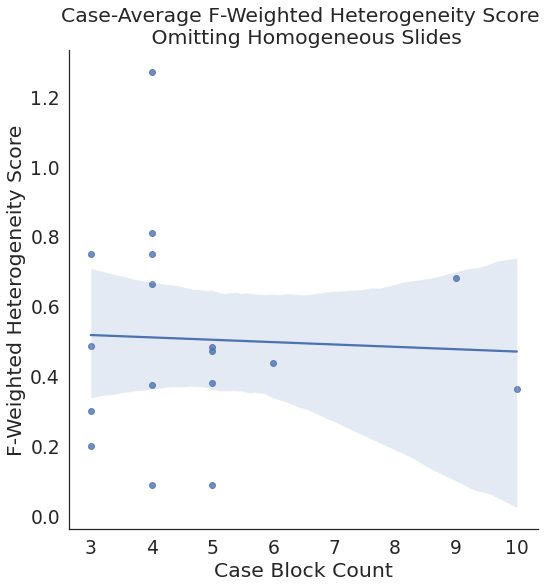

0.18386116360390023 0.4799429317114536


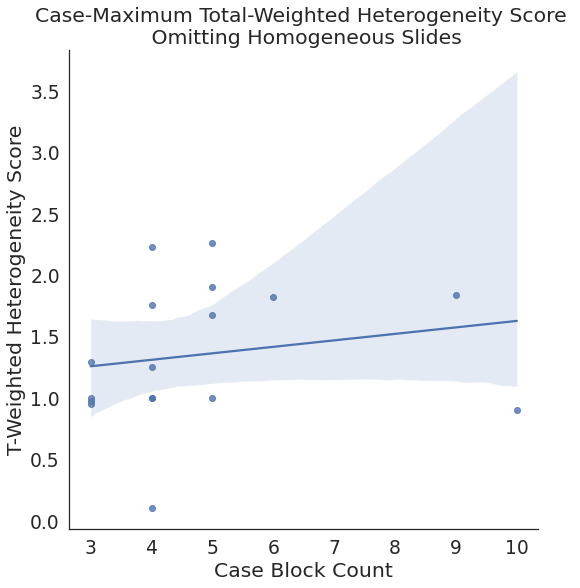

0.004452918944241444 0.9864674726009686


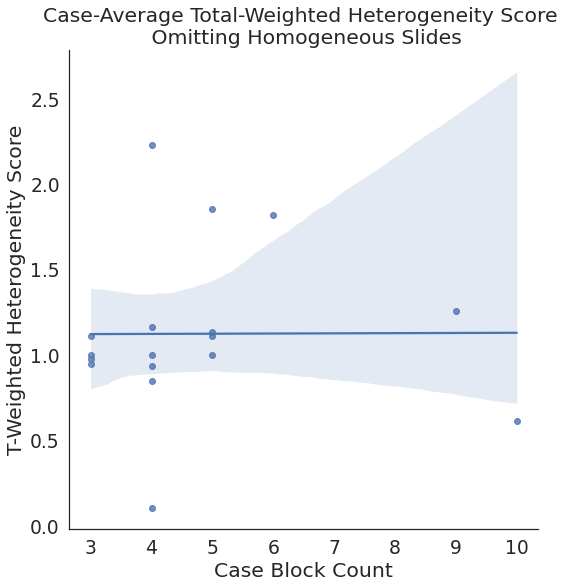

In [45]:
for prefix in ['f','t']:
    for agg_type in ['max','mean']:
        for plot_style in ['reg']:
            rho, pval = pearsonr(nonhomog['block_count'], nonhomog[f'{prefix}hs_{agg_type}'])
            print(rho, pval)
            if plot_style == 'reg':
                sns.lmplot(x=f'block_count', y=f'{prefix}hs_{agg_type}', data=nonhomog, height=8)

            set_rc(8,8,1.7)
            
            if agg_type == 'mean':
                agg_str = 'Average'
            if agg_type == 'max':
                agg_str = 'Maximum'
                
            prefix_str = 'Total' if prefix == 't' else 'F'
            plt.title(f'Case-{agg_str} {prefix_str}-Weighted Heterogeneity Score \n Omitting Homogeneous Slides')
            plt.ylabel(f'{prefix.upper()}-Weighted Heterogeneity Score')
            plt.xlabel('Case Block Count')
            plt.savefig(f'./multislide_figures/omitting_homog_{plot_style}_block_count_vs_{prefix}hs_{agg_type}_{MIN_SLIDES}plus.png', bbox_inches='tight')
            plt.show()
            
            pval_str = '[supp] [pearsonrho, pval] ' + ''f'omitting_homog_{plot_style}_block_count_vs_{prefix}hs_{agg_type}_{MIN_SLIDES}plus'
            scattered_results[pval_str] = (rho, pval)

In [46]:
MIN_SLIDES = 3
passing_case_nums = get_indices(dm.dropna(subset=['combined_het_score_f_weighted']).value_counts('case_num') >= MIN_SLIDES)

full = dm.loc[passing_case_nums].copy().reset_index()
full = full.set_index(['case_num']).join(het_freq)
full = full.groupby('case_num').aggregate(['mean','max','min','std'])
full.columns = ['_'.join(x) for x in full.columns]
full = full.join(block_counts)

0.19240721496574148 0.4033916243341775


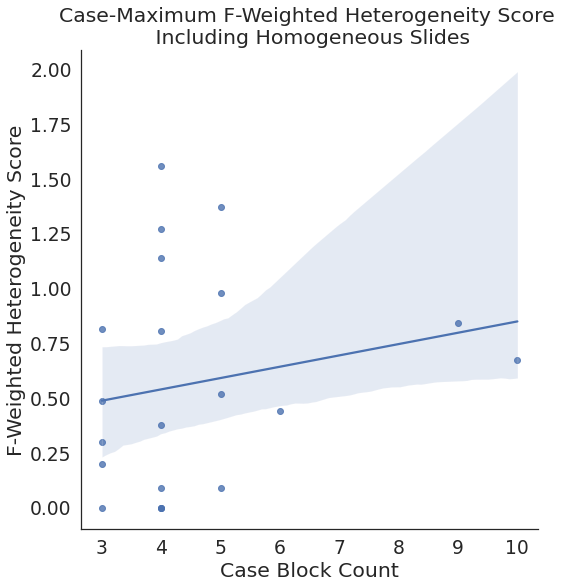

-0.02097929887031228 0.9280791722056657


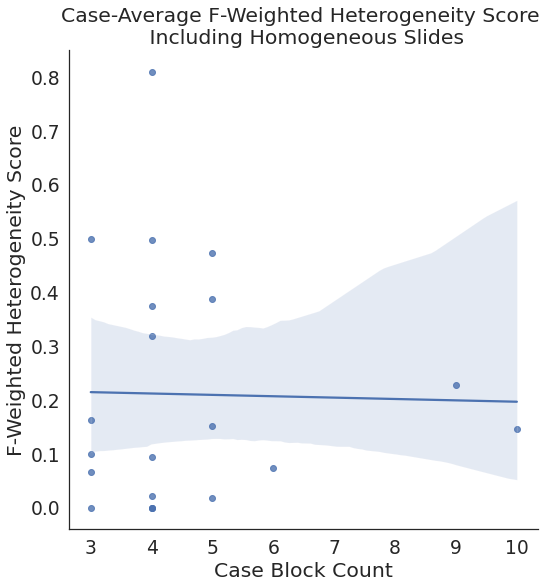

0.28443676518734384 0.2114285212852327


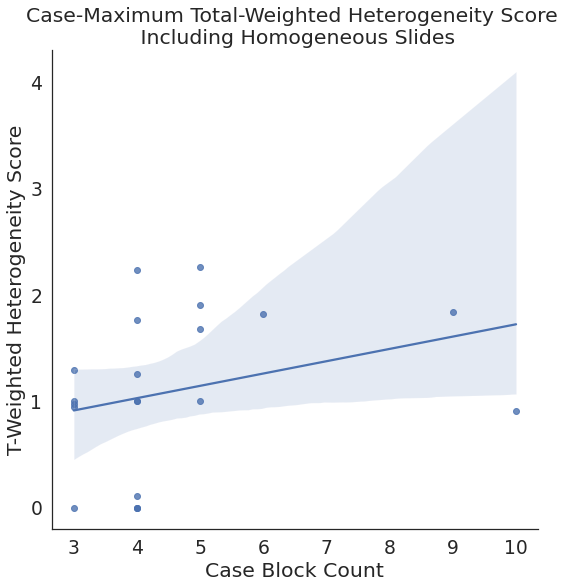

0.03154238947517046 0.8920366274096562


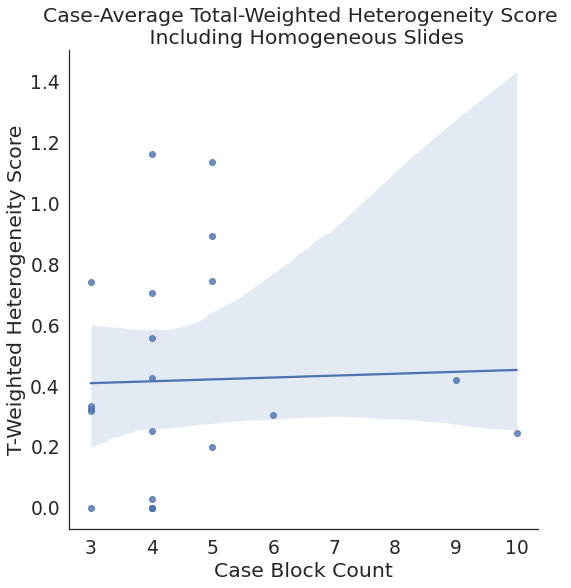

In [47]:
for prefix in ['f','t']:
    for agg_type in ['max','mean']:
        for plot_style in ['reg']:
            rho, pval = pearsonr(full['block_count'], full[f'{prefix}hs_{agg_type}'])
            print(rho, pval)
            if plot_style == 'reg':
                sns.lmplot(x=f'block_count', y=f'{prefix}hs_{agg_type}', data=full, height=8)

            set_rc(8,8,1.7)
            
            if agg_type == 'mean':
                agg_str = 'Average'
            if agg_type == 'max':
                agg_str = 'Maximum'
                
            prefix_str = 'Total' if prefix == 't' else 'F'
            plt.title(f'Case-{agg_str} {prefix_str}-Weighted Heterogeneity Score \n Including Homogeneous Slides')
            plt.ylabel(f'{prefix.upper()}-Weighted Heterogeneity Score')
            plt.xlabel('Case Block Count')
            plt.savefig(f'./multislide_figures/including_homog_{plot_style}_block_count_vs_{prefix}hs_{agg_type}_{MIN_SLIDES}plus.png', bbox_inches='tight')
            plt.show()
            
            pval_str = '[supp] [pearsonrho, pval] ' + ''f'including_homog_{plot_style}_block_count_vs_{prefix}hs_{agg_type}_{MIN_SLIDES}plus'
            scattered_results[pval_str] = (rho, pval)

In [48]:
full['gs_range'] = full['gs_max'] - full['gs_min']

0.12583102297830853 0.5867928740379823


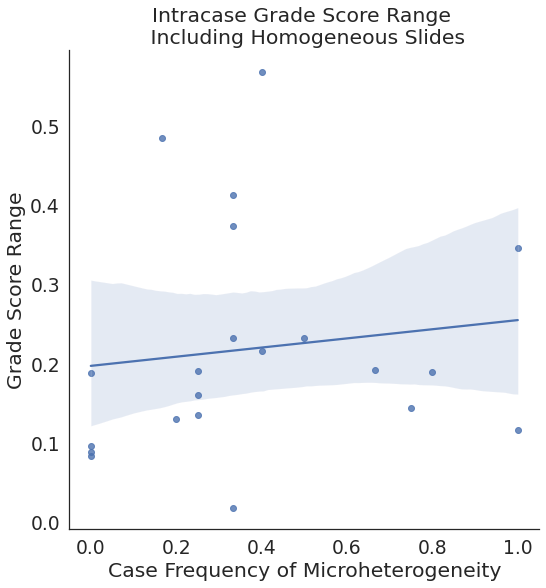

In [49]:
y = 'gs_range'
for plot_style in ['reg']:
    rho, pval = pearsonr(full['het_freq_mean'], full[y])
    print(rho, pval)
    if plot_style == 'reg':
        sns.lmplot(x=f'het_freq_mean', y=y, data=full, height=8)

    set_rc(8,8,1.7)

    if agg_type == 'mean':
        agg_str = 'Average'
    if agg_type == 'max':
        agg_str = 'Maximum'

    prefix_str = 'Total' if prefix == 't' else 'F'
    plt.title(f'Intracase Grade Score Range \n Including Homogeneous Slides')
    plt.ylabel(f'Grade Score Range')
    plt.xlabel('Case Frequency of Microheterogeneity')
    plt.savefig(f'./multislide_figures/including_homog_{plot_style}_case_mh_freq_vs_{y}_{MIN_SLIDES}plus.png', bbox_inches='tight')
    plt.show()

    pval_str = '[supp] [pearsonrho, pval] ' + ''f'including_homog_{plot_style}_case_mh_freq_vs_{y}_{MIN_SLIDES}plus'
    scattered_results[pval_str] = (rho, pval)

0.47968789799976097 0.027770349135204195


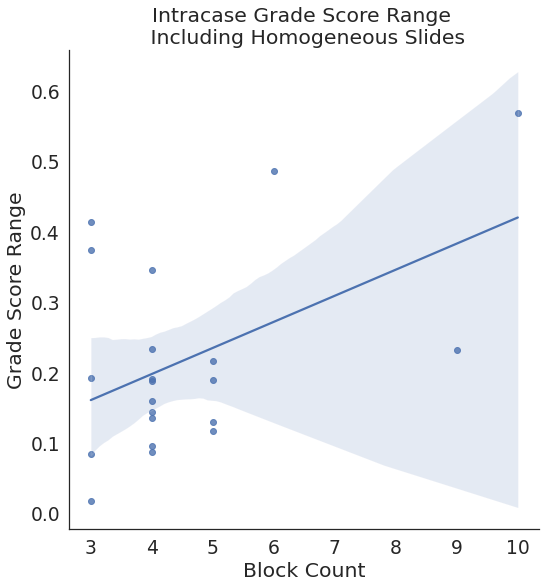

In [50]:
y = 'gs_range'
for plot_style in ['reg']:
    rho, pval = pearsonr(full['block_count'], full[y])
    print(rho, pval)
    if plot_style == 'reg':
        sns.lmplot(x=f'block_count', y=y, data=full, height=8)

    set_rc(8,8,1.7)

    if agg_type == 'mean':
        agg_str = 'Average'
    if agg_type == 'max':
        agg_str = 'Maximum'

    prefix_str = 'Total' if prefix == 't' else 'F'
    plt.title(f'Intracase Grade Score Range \n Including Homogeneous Slides')
    plt.ylabel(f'Grade Score Range')
    plt.xlabel('Block Count')
    plt.savefig(f'./multislide_figures/including_homog_{plot_style}_block_count_vs_{y}_{MIN_SLIDES}plus.png', bbox_inches='tight')
    plt.show()

    pval_str = '[supp] [pearsonrho, pval] ' + ''f'including_homog_{plot_style}_block_count_vs_{y}_{MIN_SLIDES}plus'
    scattered_results[pval_str] = (rho, pval)

0.32034872450180607 0.1568443871597145


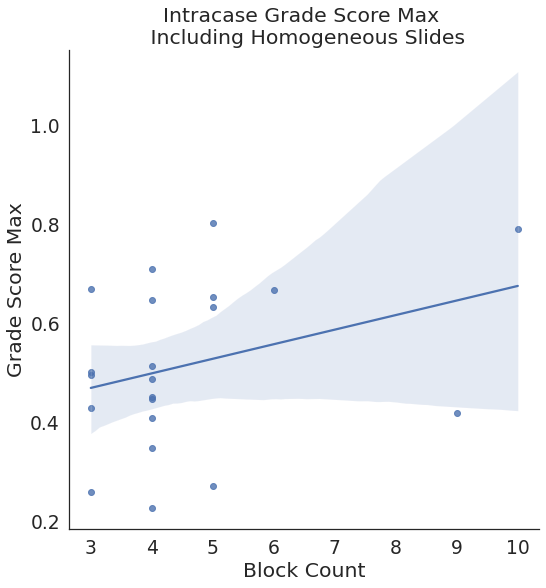

In [51]:
y = 'gs_max'
for plot_style in ['reg']:
    rho, pval = pearsonr(full['block_count'], full[y])
    print(rho, pval)
    if plot_style == 'reg':
        sns.lmplot(x=f'block_count', y=y, data=full, height=8)

    set_rc(8,8,1.7)

    if agg_type == 'mean':
        agg_str = 'Average'
    if agg_type == 'max':
        agg_str = 'Maximum'

    prefix_str = 'Total' if prefix == 't' else 'F'
    plt.title(f'Intracase Grade Score Max \n Including Homogeneous Slides')
    plt.ylabel(f'Grade Score Max')
    plt.xlabel('Block Count')
    plt.savefig(f'./multislide_figures/including_homog_{plot_style}_block_count_vs_{y}_{MIN_SLIDES}plus.png', bbox_inches='tight')
    plt.show()

    pval_str = '[supp] [pearsonrho, pval] ' + ''f'including_homog_{plot_style}_block_count_vs_{y}_{MIN_SLIDES}plus'
    scattered_results[pval_str] = (rho, pval)

0.30045669223473265 0.18570913241837342


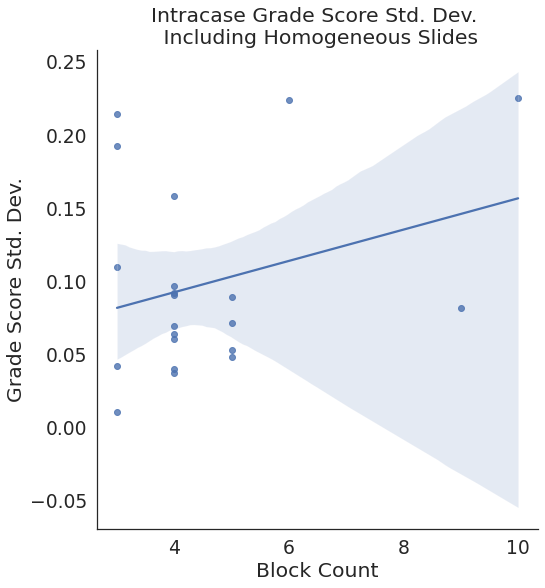

In [52]:
y = 'gs_std'
for plot_style in ['reg']:
    rho, pval = pearsonr(full['block_count'], full[y])
    print(rho, pval)
    if plot_style == 'reg':
        sns.lmplot(x=f'block_count', y=y, data=full, height=8)

    set_rc(8,8,1.7)

    if agg_type == 'mean':
        agg_str = 'Average'
    if agg_type == 'max':
        agg_str = 'Maximum'

    prefix_str = 'Total' if prefix == 't' else 'F'
    plt.title(f'Intracase Grade Score Std. Dev. \n Including Homogeneous Slides')
    plt.ylabel(f'Grade Score Std. Dev.')
    plt.xlabel('Block Count')
    plt.savefig(f'./multislide_figures/including_homog_{plot_style}_block_count_vs_{y}_{MIN_SLIDES}plus.png', bbox_inches='tight')
    plt.show()

    pval_str = '[supp] [pearsonrho, pval] ' + ''f'including_homog_{plot_style}_block_count_vs_{y}_{MIN_SLIDES}plus'
    scattered_results[pval_str] = (rho, pval)

0.1067406940844614 0.6451467439583638


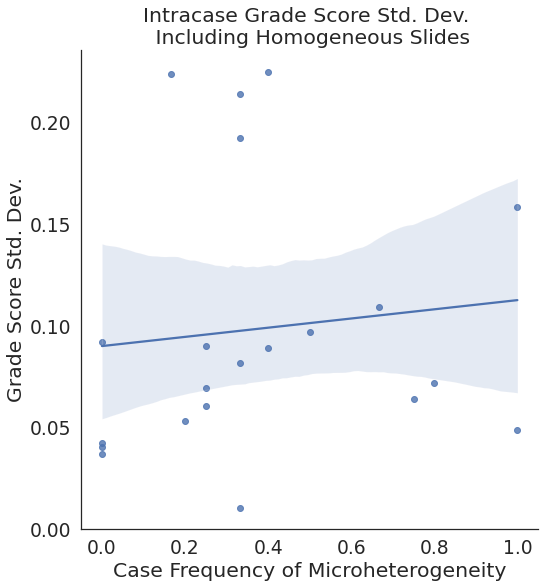

In [53]:
y = 'gs_std'
for plot_style in ['reg']:
    rho, pval = pearsonr(full['het_freq_mean'], full[y])
    print(rho, pval)
    if plot_style == 'reg':
        sns.lmplot(x=f'het_freq_mean', y=y, data=full, height=8)

    set_rc(8,8,1.7)

    if agg_type == 'mean':
        agg_str = 'Average'
    if agg_type == 'max':
        agg_str = 'Maximum'

    prefix_str = 'Total' if prefix == 't' else 'F'
    plt.title(f'Intracase Grade Score Std. Dev. \n Including Homogeneous Slides')
    plt.ylabel(f'Grade Score Std. Dev.')
    plt.xlabel('Case Frequency of Microheterogeneity')
    plt.savefig(f'./multislide_figures/including_homog_{plot_style}_case_mh_freq_vs_{y}_{MIN_SLIDES}plus.png', bbox_inches='tight')
    plt.show()

    pval_str = '[supp] [pearsonrho, pval] ' + ''f'including_homog_{plot_style}_case_mh_freq_vs_{y}_{MIN_SLIDES}plus'
    scattered_results[pval_str] = (rho, pval)

0.1067406940844614 0.6451467439583638


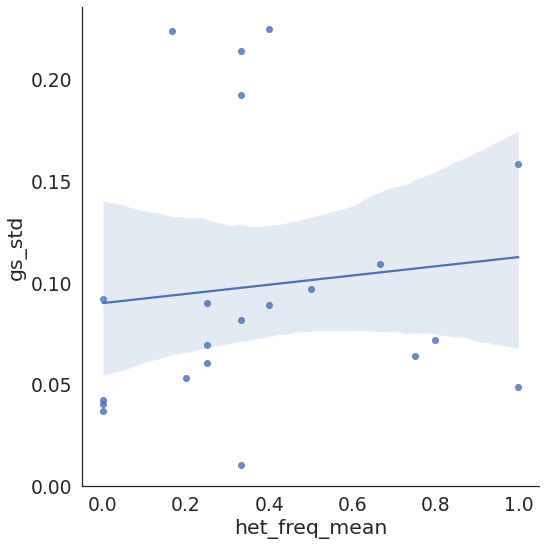

In [54]:
x = 'het_freq_mean'
y = 'gs_std'
for plot_style in ['reg']:
    rho, pval = pearsonr(full[x], full[y])
    print(rho, pval)
    if plot_style == 'reg':
        sns.lmplot(x=x, y=y, data=full, height=8)

    set_rc(8,8,1.7)

    if agg_type == 'mean':
        agg_str = 'Average'
    if agg_type == 'max':
        agg_str = 'Maximum'

    prefix_str = 'Total' if prefix == 't' else 'F'
    # plt.title(f'Intracase Grade Score Std. Dev. \n Including Homogeneous Slides')
    # plt.ylabel(f'Grade Score Std. Dev.')
    # plt.xlabel('fHS')
    # plt.savefig(f'./multislide_figures/including_homog_{plot_style}_case_mh_freq_vs_{y}_{MIN_SLIDES}plus.png', bbox_inches='tight')
    plt.show()

    # pval_str = '[supp] [pearsonrho, pval] ' + ''f'including_homog_{plot_style}_case_mh_freq_vs_{y}_{MIN_SLIDES}plus'
    scattered_results[pval_str] = (rho, pval)

0.14412729168966582 0.5330878609681082


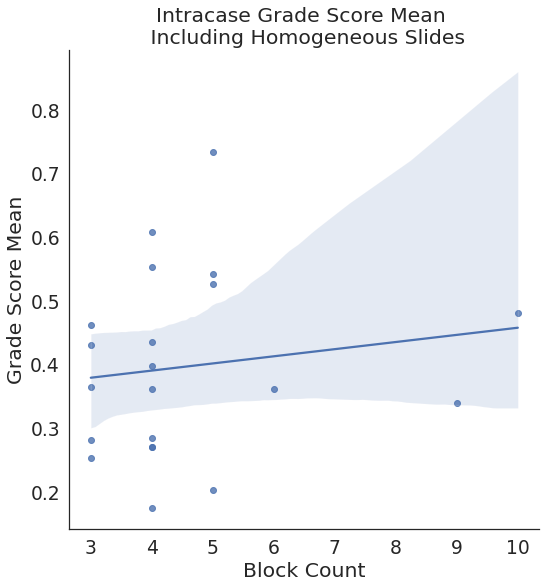

In [55]:
y = 'gs_mean'
for plot_style in ['reg']:
    rho, pval = pearsonr(full['block_count'], full[y])
    print(rho, pval)
    if plot_style == 'reg':
        sns.lmplot(x=f'block_count', y=y, data=full, height=8)

    set_rc(8,8,1.7)

    if agg_type == 'mean':
        agg_str = 'Average'
    if agg_type == 'max':
        agg_str = 'Maximum'

    prefix_str = 'Total' if prefix == 't' else 'F'
    plt.title(f'Intracase Grade Score Mean \n Including Homogeneous Slides')
    plt.ylabel(f'Grade Score Mean')
    plt.xlabel('Block Count')
    plt.savefig(f'./multislide_figures/including_homog_{plot_style}_block_count_vs_{y}_{MIN_SLIDES}plus.png', bbox_inches='tight')
    plt.show()

    pval_str = '[supp] [pearsonrho, pval] ' + ''f'including_homog_{plot_style}_block_count_vs_{y}_{MIN_SLIDES}plus'
    scattered_results[pval_str] = (rho, pval)

0.8289921927586031 3.419586157387227e-06


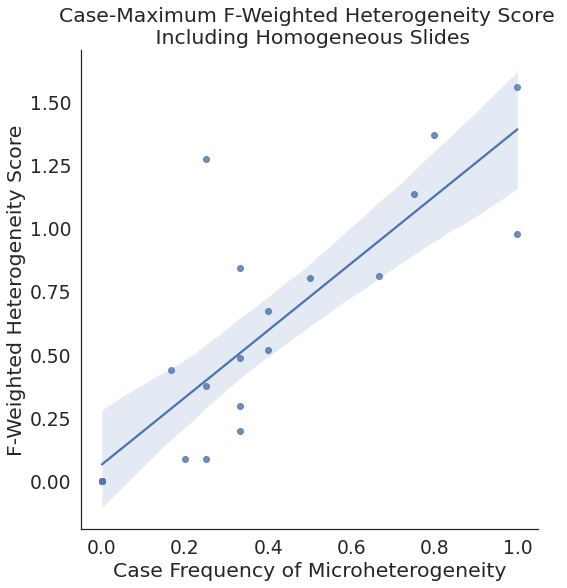

0.8289921927586031 3.419586157387227e-06


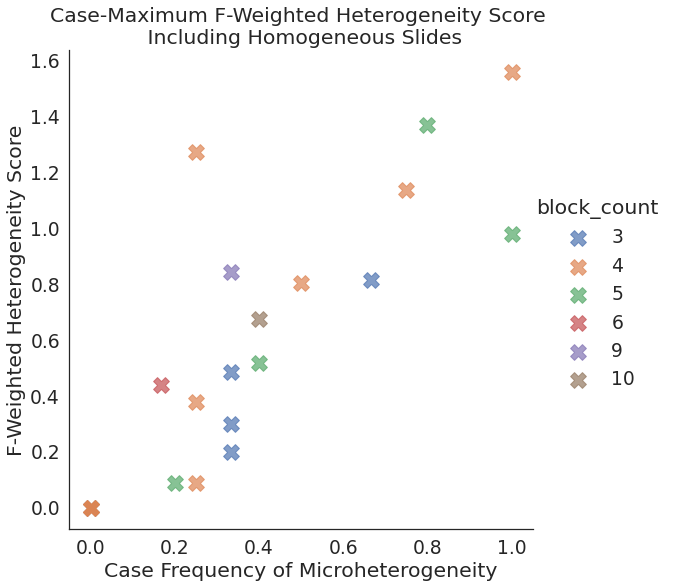

0.9040762334498671 1.911749611005403e-08


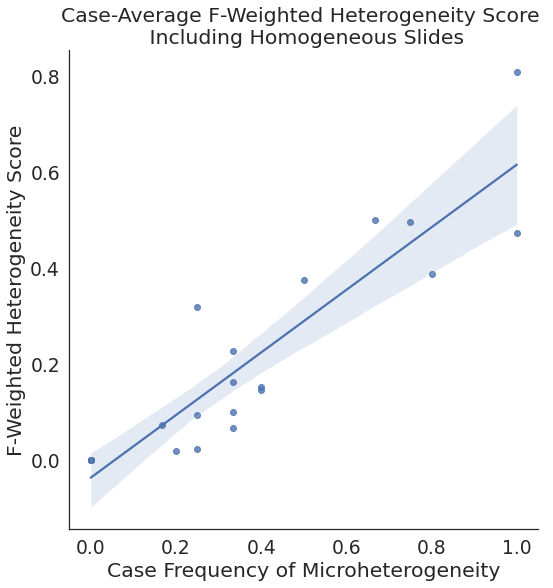

0.9040762334498671 1.911749611005403e-08


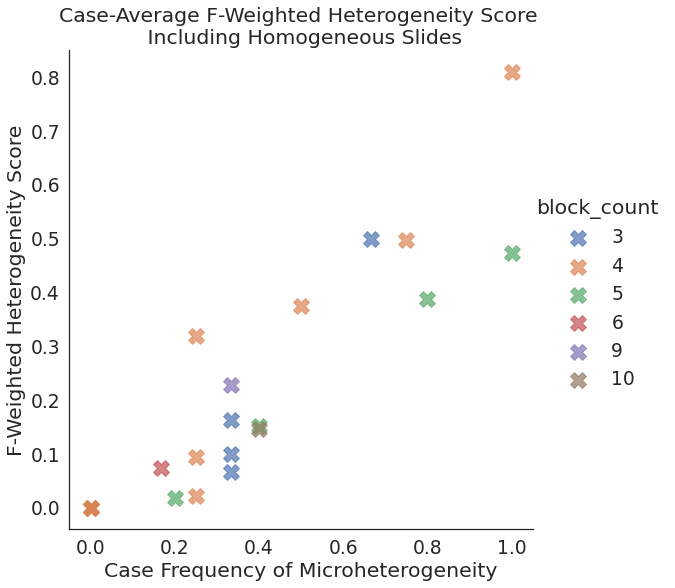

0.6281144672182222 0.0022963783325292814


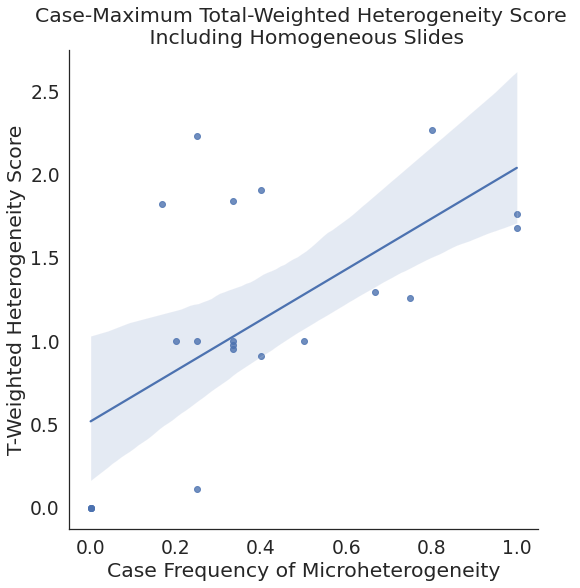

0.6281144672182222 0.0022963783325292814


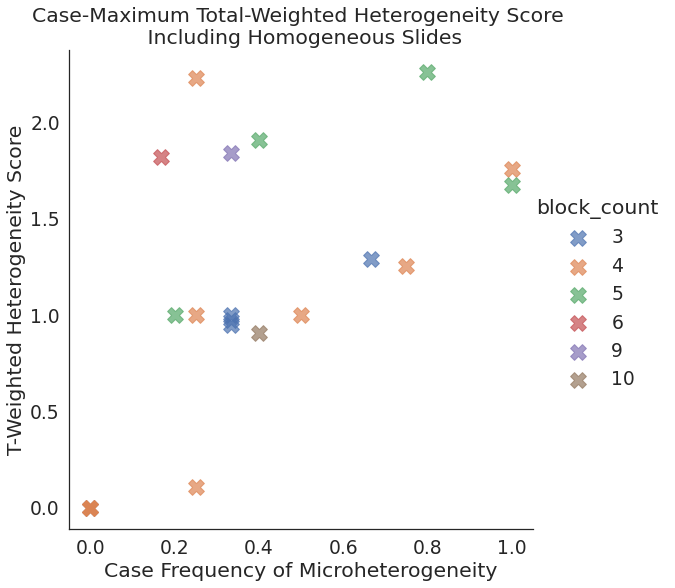

0.9344113532282672 5.826930131668322e-10


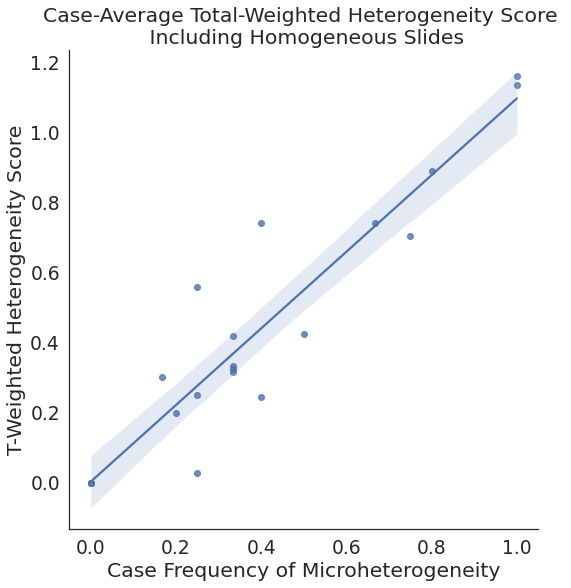

0.9344113532282672 5.826930131668322e-10


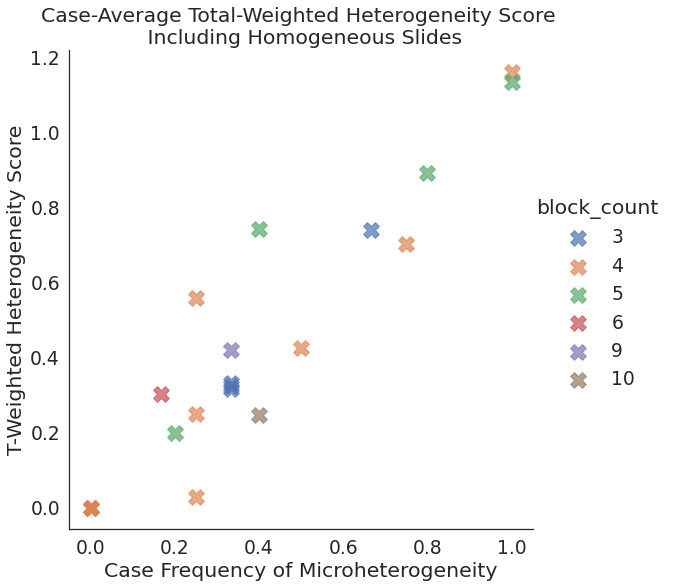

In [56]:
for prefix in ['f','t']:
    for agg_type in ['max','mean']:
        for plot_style in ['reg','hue_mark']:
            rho, pval = pearsonr(full['het_freq_mean'], full[f'{prefix}hs_{agg_type}'])
            print(rho, pval)
            if plot_style == 'reg':
                sns.lmplot(x=f'het_freq_mean', y=f'{prefix}hs_{agg_type}', data=full, height=8)
                # plt.axhline(score_avgs_full[prefix], c='r', ls='--')

            else:
                sns.lmplot(x='het_freq_mean', y=f'{prefix}hs_{agg_type}', hue='block_count', markers='X', fit_reg=False, data=full, height=8, scatter_kws={'s':250, 'alpha':.7})

            set_rc(8,8,1.7)
            
            if agg_type == 'mean':
                agg_str = 'Average'
            if agg_type == 'max':
                agg_str = 'Maximum'
                
            prefix_str = 'Total' if prefix == 't' else 'F'
            plt.title(f'Case-{agg_str} {prefix_str}-Weighted Heterogeneity Score \n Including Homogeneous Slides')
            plt.ylabel(f'{prefix.upper()}-Weighted Heterogeneity Score')
            plt.xlabel('Case Frequency of Microheterogeneity')
            plt.savefig(f'./multislide_figures/including_homog_{plot_style}_{prefix}hs_{agg_type}_{MIN_SLIDES}plus.png', bbox_inches='tight')
            plt.show()
            
            pval_str = '[supp] [pearsonrho, pval] ' + ''f'including_homog_{plot_style}_case_mh_freq_vs_{prefix}hs_{agg_type}_{MIN_SLIDES}plus'
            scattered_results[pval_str] = (rho, pval)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


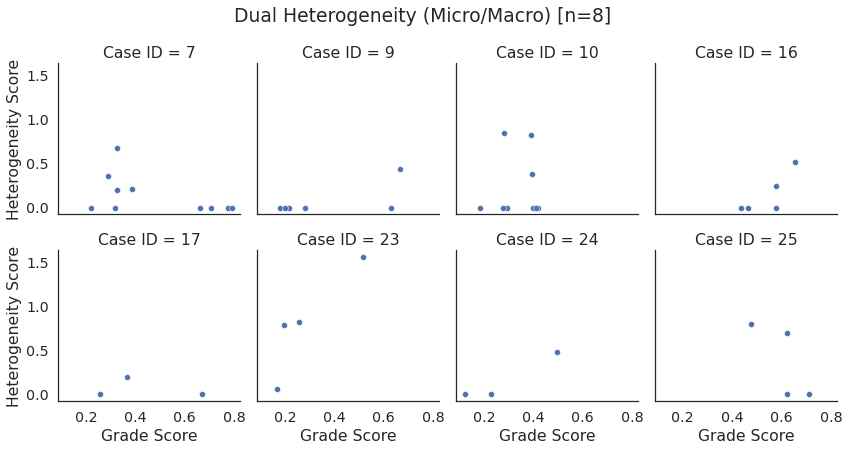

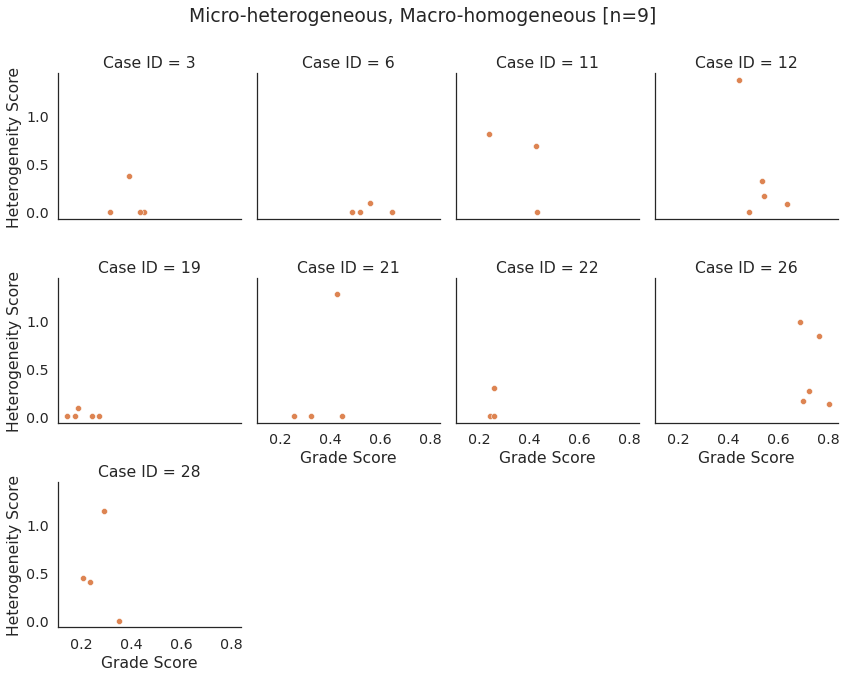

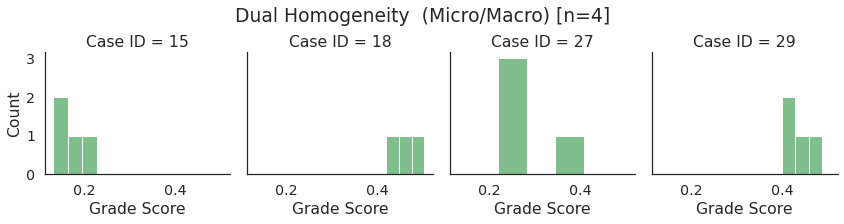

In [57]:
MIN_SLIDES = 3
passing_case_nums = get_indices(dm.dropna(subset=['combined_het_score_f_weighted']).value_counts('case_num') >= MIN_SLIDES)

plot_df = dm.loc[passing_case_nums].copy().reset_index()
plot_df = plot_df.set_index('case_num').join(df['joint_class']).reset_index()

plot_df['Case ID'] = plot_df['case_num'].astype(str)
plot_df['Grade Score'] = plot_df['grade_score']
plot_df['Heterogeneity Score'] = plot_df['combined_het_score_f_weighted']

col_wrap = 4

set_rc(font_scale=1.3)

sub = plot_df.loc[plot_df['joint_class'] == 'dual_heterogeneity']
n = len(sub['case_num'].unique())

g = sns.FacetGrid(data=sub, col='Case ID', hue='joint_class', hue_order=['dual_heterogeneity','hs_het_only','dual_homogeneity'], col_wrap = col_wrap)
g.map_dataframe(sns.scatterplot, x='Grade Score', y='Heterogeneity Score')
plt.suptitle(f'Dual Heterogeneity (Micro/Macro) [n={n}]',y=1.05)
plt.savefig('./multislide_figures/fhs_vs_gs__dual_heterogeneous_3plus.png', bbox_inches='tight')
plt.show()

sub = plot_df.loc[plot_df['joint_class'] == 'hs_het_only']
n = len(sub['case_num'].unique())

g = sns.FacetGrid(data=sub, col='Case ID',  hue='joint_class', hue_order=['dual_heterogeneity','hs_het_only','dual_homogeneity'], col_wrap = col_wrap)
g.map_dataframe(sns.scatterplot, x='Grade Score', y='Heterogeneity Score')
plt.suptitle(f'Micro-heterogeneous, Macro-homogeneous [n={n}]',y=1.05)
plt.savefig('./multislide_figures/fhs_vs_gs__hs_het_only_3plus.png', bbox_inches='tight')
plt.show()


sub = plot_df.loc[plot_df['joint_class'] == 'dual_homogeneity']
n = len(sub['case_num'].unique())

g = sns.FacetGrid(data=sub, col='Case ID', col_wrap = col_wrap, hue='joint_class', hue_order=['dual_heterogeneity','hs_het_only','dual_homogeneity'])
g.map_dataframe(sns.histplot, x='Grade Score')
plt.suptitle(f'Dual Homogeneity  (Micro/Macro) [n={n}]',y=1.05)
plt.savefig('./multislide_figures/fhs_vs_gs__dual_homogeneity_3plus.png', bbox_inches='tight')
plt.show()


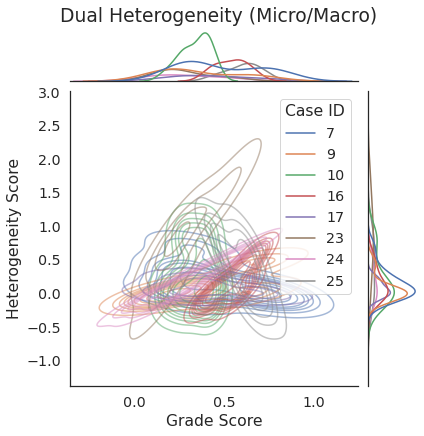

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


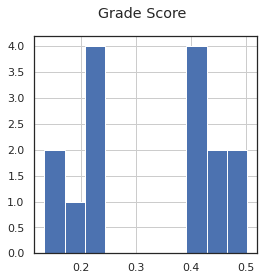

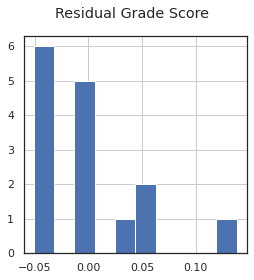

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


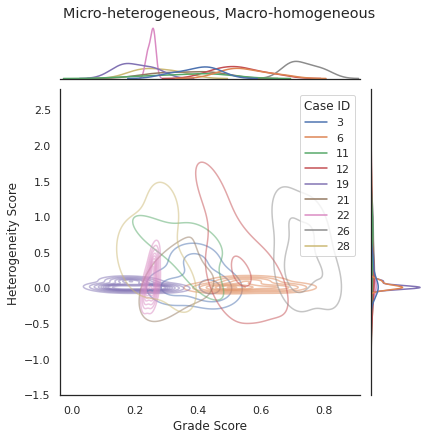

hs_het_only           9
dual_heterogeneity    8
dual_homogeneity      4
Name: joint_class, dtype: int64


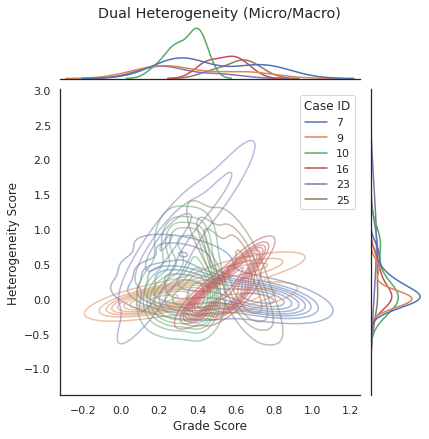

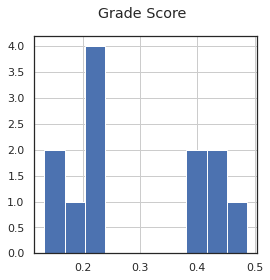

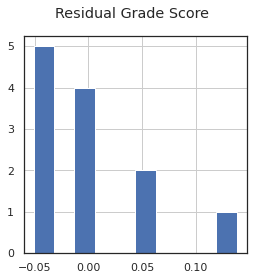

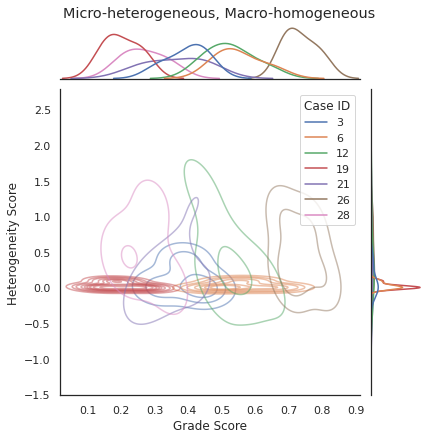

hs_het_only           7
dual_heterogeneity    6
dual_homogeneity      3
Name: joint_class, dtype: int64


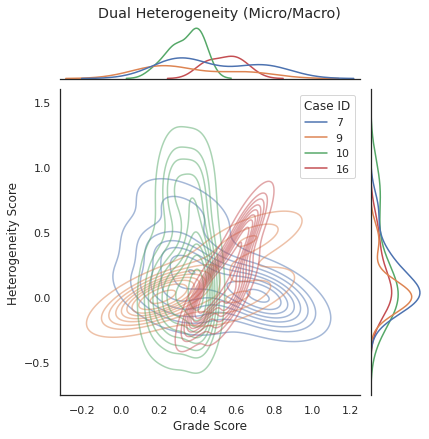

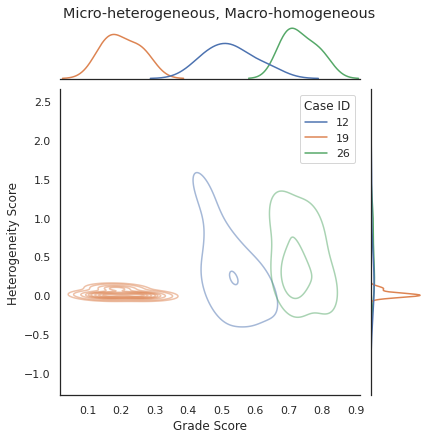

dual_heterogeneity    4
hs_het_only           3
Name: joint_class, dtype: int64


In [58]:
for MIN_SLIDES in [3,4,5]:
    passing_case_nums = get_indices(dm.dropna(subset=['combined_het_score_f_weighted']).value_counts('case_num') >= MIN_SLIDES)

    plot_df = dm.loc[passing_case_nums].copy().reset_index()
    plot_df = plot_df.set_index('case_num').join(df['joint_class']).reset_index()

    plot_df['Case ID'] = plot_df['case_num'].astype(str)
    plot_df['Grade Score'] = plot_df['grade_score']
    plot_df['Heterogeneity Score'] = plot_df['combined_het_score_f_weighted']

    for joint_class, subdf in plot_df.groupby('joint_class'):
        if joint_class != 'dual_homogeneity':
            sns.jointplot(x='Grade Score', y='Heterogeneity Score', hue='Case ID', kind='kde', data=subdf, fill=False, levels=10, alpha=0.5,)
            if joint_class == 'hs_het_only':
                joint_class_label = 'Micro-heterogeneous, Macro-homogeneous'
                
            if joint_class == 'dual_heterogeneity':
                joint_class_label = 'Dual Heterogeneity (Micro/Macro)'

            plt.suptitle(f'{joint_class_label}',y=1.015)
            plt.savefig(f'./multislide_figures/kdeplot_{joint_class}_{MIN_SLIDES}plus.png', bbox_inches='tight')
            
            plt.show()
        else:
            set_rc(4,4)
            plt.suptitle('Grade Score')
            subdf['Grade Score'].hist()
            plt.savefig(f'./multislide_figures/histplot_gs_{joint_class}_{MIN_SLIDES}plus.png', bbox_inches='tight')
            plt.show()
            plt.suptitle('Residual Grade Score')
            subdf['residual_grade_score'].hist()
            plt.savefig(f'./multislide_figures/histplot_residual_gs_{joint_class}_{MIN_SLIDES}plus.png', bbox_inches='tight')
            plt.show()
            
    
    print(plot_df.drop_duplicates('case_num').joint_class.value_counts())


---

### Null testing: expected microhet vs observed at different splits of cohort

In [59]:
from scipy.stats import beta, betabinom

### Beta-Binomial Instead of Empirical Mean Frequency for Null p?
- $p(\theta) \propto Binom(n,p) * Beta(\alpha, \beta) ~ Beta(\alpha + s, \beta + f)$

### Base a beta prior on cm025 cohort for more appropriate use of Beta-Binomial in the predictive context

In [60]:
paper_fts = pd.read_csv('/home/jupyter/rerun_final_patient_features.csv', index_col=0)

paper_cm025 = prepare_cm025_subset(paper_fts,drug_type='any',use_risk_group_info=False, relabel_edge_cats=False)

f = paper_cm025.value_counts(['any_diff_edge'])[False]
s = paper_cm025.value_counts(['any_diff_edge'])[True]
    
s,f

selecting cm025 only
(623, 147)
dropping unusable data (grade seg based)
(569, 147)
dropping entries missing any in ['os', 'os_event', 'age_at_diagnosis', 'gender']
renaming updated_nonstroma_grade_mean to nonstroma_grade_mean temporarily
(542, 147)
grade quantile bins:  [0.15729222 0.68477528 0.84331957 0.9979857 ]
(542, 148)
dropping low tumor tile count cases
(542, 148)
dropping G1 [keeping unannotated cases]
(541, 148)
dropping metastatic biopsies
(427, 148)
keeping all stages 
(427, 148)


(148, 279)

In [61]:
s, f

(148, 279)

In [62]:
s/(s+f)

0.34660421545667447

In [63]:
from scipy.stats import beta, betabinom

3 0.25
4 0.2
5 0.16666666666666669
6 0.14285714285714288
9 0.09999999999999998
10 0.0909090909090909


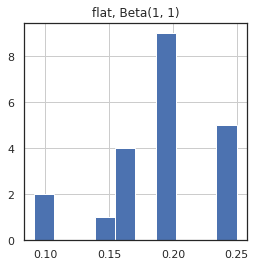

3 0.30000000000000016
4 0.25714285714285734
5 0.2142857142857143
6 0.19047619047619033
9 0.13636363636363644
10 0.12587412587412594


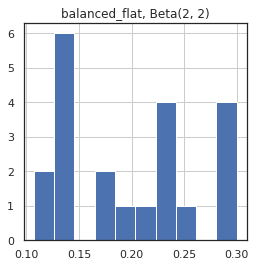

3 0.4423528772528513
4 0.38501083760904337
5 0.33343894712092875
6 0.32614016832448384
9 0.2693241402665323
10 0.25122865008576806


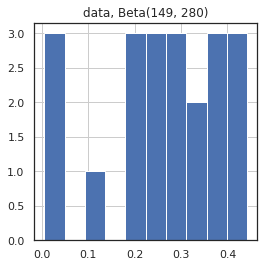

In [64]:
set_rc(4,4)

meta_results = {}

alpha, beta = 1, 1

prior_conc_map = {
    'flat':(1,1),
    'balanced_flat':(2,2),
    'data':(alpha+s, beta+f)
}

for prior_type in ['flat','balanced_flat','data']:
    results = pd.DataFrame()

    alpha, beta = 1, 1
    
    a,b = prior_conc_map[prior_type]


    for n, subdf in df.sort_values(by='block_count').groupby('block_count'):
        # print(n)

        bb_dist = betabinom(n, a, b)
        support = range(0, n+1)
        
        mle_density = bb_dist.pmf(support).max()
        print(n,mle_density)
        
        # print(a,b,'\n')
        # plt.title(f'BetaBinom({n}, {a}, {b})')
        # plt.scatter(bb_range, [bb_dist.pmf(k) for k in bb_range])
        # plt.show()

        observation_probs = bb_dist.pmf(subdf['het_count'])
        observation_cdf_vals = bb_dist.cdf(subdf['het_count'])

        cdf_zero_het = bb_dist.cdf(0)
        cdf_one_het = bb_dist.cdf(1)

        subdf['betabinom_mle_density'] = mle_density
        subdf['betabinom_p'] = observation_probs
        
        
        subdf['betabinom_cdf'] = observation_cdf_vals
        subdf['betabinom_expect'] = bb_dist.expect()
        subdf['betabinom_stdev'] = bb_dist.std()

        subdf['betabinom_cdf_0'] = cdf_zero_het
        subdf['betabinom_cdf_1'] = cdf_one_het

        results = pd.concat([results, subdf])
        # plt.hist(observation_probs)
        # plt.show()

    results['betabinom_prob_1+'] = 1 - results['betabinom_cdf_0']
    results['betabinom_prob_2+'] = 1 - results['betabinom_cdf_1']
    results['-log10(betabinom_p)'] = -np.log10(results['betabinom_p'])
    results['relative_betabinom_p'] = results['betabinom_p']/results['betabinom_mle_density']
    results['neg_log_relative_binom_p'] = -np.log(results['relative_betabinom_p'])

    results['betabinom_p'].hist()
    plt.title(f'{prior_type}, Beta({a}, {b})')
    plt.show()
    meta_results[prior_type] = results

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


Text(336.9714285714286, 0.5, 'Observed Het. Slides')

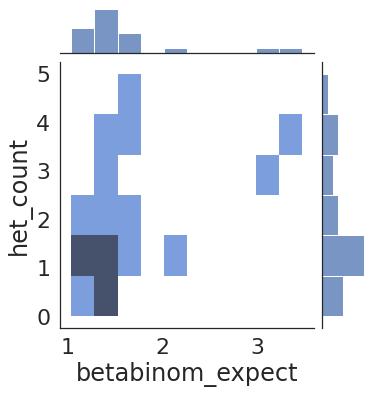

In [65]:
set_rc(8,8,2)
g = sns.jointplot(x='betabinom_expect', y='het_count', data=meta_results['data'], kind='hist')
plt.xlabel('Expected Het. Slides (Beta-Binomial, CM025 Prior)')
plt.ylabel('Observed Het. Slides')

In [66]:
from lifelines.statistics import _chisq_test_p_value
import scipy.stats as stats

def llrt(ll_alt, ll_null, degrees_freedom):
    test_stat = 2 * ll_alt - 2 * ll_null
    # print(test_stat)
    p_value = stats.chi2.sf(test_stat, degrees_freedom)

    return p_value

In [67]:
# # null = np.log(meta_results['flat']['betabinom_p'])

# null = np.log(meta_results['data']['betabinom_mle_density'])
# alt = np.log(meta_results['data']['betabinom_p'])
# likelihoods = pd.DataFrame({'null':null, 'alt':alt})
# chisq_pvals = likelihoods.apply(lambda x: llrt(x['null'], x['alt'], 3), 1)

# chisq_pvals.hist()

### Condition on a reference slide

In [68]:
set_rc(4,4)

results = pd.DataFrame()

score_col = 'combined_het_score_f_weighted'
selection_cols = ['grade_score','slide_seg_max','slide_seg_maxes_10_area_frac_min','slide_seg_maxes_25_area_frac_min']

for selection_col in selection_cols:
    updating_results = pd.DataFrame()

    for case_id, case_df in dm.groupby(['case_num']):
        n = len(case_df)

        if selection_col != 'random':
            reformatted = case_df.set_index(['block_num'])
            reference_slide_id = reformatted[selection_col].idxmax()
            reference_slide = reformatted.loc[reference_slide_id]
            query_data = reformatted.drop(reference_slide_id)
            indicator = np.any(query_data[score_col] > 0)

            if reference_slide['any_diff_edge']:
                a, b = 2, 1
            else:
                a, b = 1, 2

            observed_het_counts = query_data['any_diff_edge'].sum()
            bb_dist = betabinom(n-1, a, b)
            support = range(0, n)

            mle_density = bb_dist.pmf(support).max()
            prob_observation = bb_dist.pmf(observed_het_counts)
            # print('n ', n)
            # print('mle ',mle_density)
            # print('obs ',prob_observation, '\n')
    
            updating_results.loc[case_id,'prob_observation_based_on_top_slide'] = prob_observation
            updating_results.loc[case_id,'expected_hits'] = bb_dist.expect()
            updating_results.loc[case_id,'observed_hits_in_query'] = observed_het_counts
            updating_results['selection_col'] = selection_col
    updating_results.index.name = 'case_id'
    
    results = pd.concat([results, updating_results])
    


In [69]:
for selection_col in selection_cols:
    print('\n =====================================')
    alt_ll = np.log(results.loc[results['selection_col'] == selection_col]['prob_observation_based_on_top_slide']).sum()
    null_ll = np.log(meta_results['data']['betabinom_p']).sum()
    pval = llrt(alt_ll, null_ll, 1)
    print(f'Top {selection_col}: Beta(1+i, 1+i): LLRT pval = {pval :.3f}')
    print(f'Alt LL: {alt_ll :.3f}, Null LL: {null_ll :.3f} \n')

    alt_ll = np.log(results.loc[results['selection_col'] == selection_col]['prob_observation_based_on_top_slide']).sum()
    null_ll = np.log(meta_results['flat']['betabinom_p']).sum()
    pval = llrt(alt_ll, null_ll, 1)
    print(f'Flat, Beta(1,1) prior: LLRT pval = {pval :.3f}' )  # I think d.f. = 1? since the only dimensionality increase is from observing the indicator of top slide? otherwise same dims for betabinomial params
    print(f'Alt LL: {alt_ll :.3f}, Null LL: {null_ll :.3f} \n')
    
    alt_ll = np.log(results.loc[results['selection_col'] == selection_col]['prob_observation_based_on_top_slide']).sum()
    null_ll = np.log(meta_results['balanced_flat']['betabinom_p']).sum()
    # print(alt_ll, null_ll)
    pval = llrt(alt_ll, null_ll, 1)
    print(f'Centered, Beta(2,2) prior: LLRT pval = {pval :.3f}' )  # I think d.f. = 1? since the only dimensionality increase is from observing the indicator of top slide? otherwise same dims for betabinomial params
    print(f'Alt LL: {alt_ll :.3f}, Null LL: {null_ll :.3f} \n')


Top grade_score: Beta(1+i, 1+i): LLRT pval = 0.020
Alt LL: -32.722, Null LL: -35.413 

Flat, Beta(1,1) prior: LLRT pval = 0.025
Alt LL: -32.722, Null LL: -35.230 

Centered, Beta(2,2) prior: LLRT pval = 0.042
Alt LL: -32.722, Null LL: -34.798 


Top slide_seg_max: Beta(1+i, 1+i): LLRT pval = 0.154
Alt LL: -34.396, Null LL: -35.413 

Flat, Beta(1,1) prior: LLRT pval = 0.197
Alt LL: -34.396, Null LL: -35.230 

Centered, Beta(2,2) prior: LLRT pval = 0.370
Alt LL: -34.396, Null LL: -34.798 


Top slide_seg_maxes_10_area_frac_min: Beta(1+i, 1+i): LLRT pval = 0.006
Alt LL: -31.624, Null LL: -35.413 

Flat, Beta(1,1) prior: LLRT pval = 0.007
Alt LL: -31.624, Null LL: -35.230 

Centered, Beta(2,2) prior: LLRT pval = 0.012
Alt LL: -31.624, Null LL: -34.798 


Top slide_seg_maxes_25_area_frac_min: Beta(1+i, 1+i): LLRT pval = 0.013
Alt LL: -32.317, Null LL: -35.413 

Flat, Beta(1,1) prior: LLRT pval = 0.016
Alt LL: -32.317, Null LL: -35.230 

Centered, Beta(2,2) prior: LLRT pval = 0.026
Alt LL: 

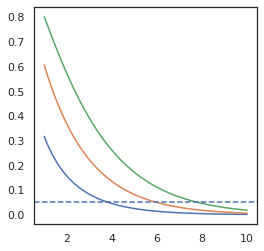

In [70]:
plt.plot(np.linspace(1,10,100), [stats.chi2.sf(x, 1) for x in np.linspace(1,10,100)])
plt.plot(np.linspace(1,10,100), [stats.chi2.sf(x, 2) for x in np.linspace(1,10,100)])
plt.plot(np.linspace(1,10,100), [stats.chi2.sf(x, 3) for x in np.linspace(1,10,100)])
plt.axhline(0.05, ls='--')

### Condition on a reference slide, but account for very close GS scoring 

In [71]:
prev_results = results.copy()

In [72]:
selection_cols

['grade_score',
 'slide_seg_max',
 'slide_seg_maxes_10_area_frac_min',
 'slide_seg_maxes_25_area_frac_min']

In [73]:
for col in selection_cols[1:]:
    col_name = f'residual_{col}_max'
    dm[col_name] = dm.groupby('case_num')[col].apply(lambda x: x-x.max())

In [74]:
0.025/4

0.00625

In [75]:
set_rc(4,4)

min_slides = 3

results = pd.DataFrame()

score_col = 'combined_het_score_f_weighted'

updating_scale = 1

gs_margin_cutoffs = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2]

for gs_margin_cutoff in gs_margin_cutoffs:
    for selection_col in selection_cols:

        updating_results = pd.DataFrame(columns=['case_num','block_num']).set_index(['case_num','block_num'])

        for case_id, case_df in dm.groupby(['case_num']):
            n = len(case_df)
            
            if n >= min_slides:
                # print('\n', n)
                reformatted = case_df.set_index(['block_num'])
                
                max_resid_col = f'residual_{selection_col}_max'
                
                if np.any(case_df.loc[case_df[max_resid_col] != 0, max_resid_col].abs() < gs_margin_cutoff):
                    top_reference_slide_id = reformatted[selection_col].idxmax()

                    subdf = case_df.loc[case_df[max_resid_col].abs() <= gs_margin_cutoff]
                    aggregate_scores = []
                    # print(subdf['residual_grade_score_max'])
                    for reference_slide_id in subdf['block_num'].unique():
                        # print(case_id,reference_slide_id)
                        reference_slide = reformatted.loc[reference_slide_id]
                        query_data = reformatted.drop(reference_slide_id)

                        if reference_slide['any_diff_edge']:
                            a, b = 2, 1
                        else:
                            a, b = 1, 2

                        observed_het_counts = query_data['any_diff_edge'].sum()
                        bb_dist = betabinom(n-1, a, b)
                        support = range(0, n)

                        mle_density = bb_dist.pmf(support).max()
                        prob_observation = bb_dist.pmf(observed_het_counts)

                        updating_results.loc[(case_id, reference_slide_id),'prob_observation_based_on_top_slide'] = prob_observation
                        updating_results.loc[(case_id, reference_slide_id),'expected_hits'] = bb_dist.expect()
                        updating_results.loc[(case_id, reference_slide_id),'observed_hits_in_query'] = observed_het_counts
                        updating_results.loc[(case_id, reference_slide_id),'query_data_size'] = len(query_data)
                        updating_results.loc[(case_id, reference_slide_id),'num_top_slides_considered'] = len(subdf)
                        updating_results.loc[(case_id, reference_slide_id),'block_count'] = n

                else:
                    reformatted = case_df.set_index(['block_num'])
                    reference_slide_id = reformatted[selection_col].idxmax()
                    reference_slide = reformatted.loc[reference_slide_id]
                    query_data = reformatted.drop(reference_slide_id)
                    indicator = np.any(query_data[score_col] > 0)
                    # grouped_results.append((reference_slide[score_col], indicator))

                    if reference_slide['any_diff_edge']:
                        a, b = s+updating_scale, f
                    else:
                        a, b = s, f+updating_scale

                    observed_het_counts = query_data['any_diff_edge'].sum()
                    bb_dist = betabinom(n-1, a, b)
                    support = range(0, n)

                    mle_density = bb_dist.pmf(support).max()
                    prob_observation = bb_dist.pmf(observed_het_counts)

                    updating_results.loc[(case_id, reference_slide_id),'prob_observation_based_on_top_slide'] = prob_observation
                    updating_results.loc[(case_id, reference_slide_id),'expected_hits'] = bb_dist.expect()
                    updating_results.loc[(case_id, reference_slide_id),'observed_hits_in_query'] = observed_het_counts
                    updating_results.loc[(case_id, reference_slide_id),'query_data_size'] = len(query_data)
                    updating_results.loc[(case_id, reference_slide_id),'num_top_slides_considered'] = 1
                    updating_results.loc[(case_id, reference_slide_id),'block_count'] = n

            updating_results['selection_col'] = selection_col
            updating_results['gs_margin_cutoff'] = gs_margin_cutoff
            updating_results.index.name = 'case_id'

        results = pd.concat([results, updating_results])
    
results['frac_considered'] = results['num_top_slides_considered'] / results['block_count']

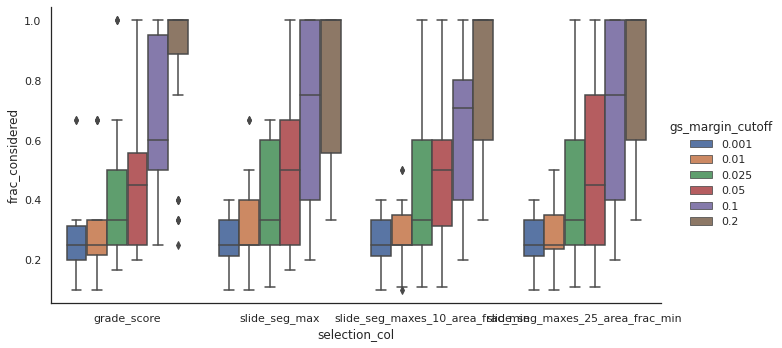

In [76]:
set_rc(12,5)
sns.catplot(x='selection_col', y='frac_considered', hue='gs_margin_cutoff', kind='box', data=results,aspect=1.9)

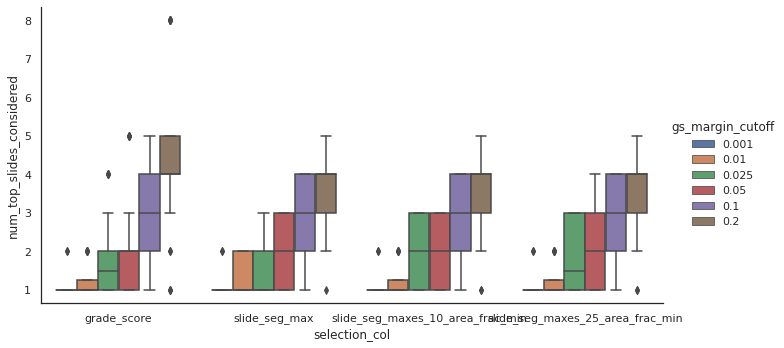

In [77]:
set_rc(12,5)
sns.catplot(x='selection_col', y='num_top_slides_considered', hue='gs_margin_cutoff', kind='box', data=results,aspect=1.9)

In [78]:
dm['residual_grade_score_max'].groupby('case_num').mean().sort_values()

case_num
7    -0.309499
9    -0.305212
17   -0.238945
23   -0.230891
24   -0.213948
27   -0.138056
4    -0.111747
16   -0.111490
12   -0.106569
25   -0.101689
6    -0.094912
21   -0.084949
10   -0.079176
28   -0.078923
19   -0.068415
26   -0.068347
11   -0.065607
13   -0.056696
3    -0.053447
15   -0.052645
29   -0.051202
20   -0.042634
18   -0.040595
2    -0.011461
1    -0.007148
22   -0.006441
8     0.000000
5     0.000000
Name: residual_grade_score_max, dtype: float64

In [79]:
dm.loc[22][['residual_grade_score_max']]

residual_grade_score_max
case_num                          
22                       -0.000801
22                       -0.018521
22                        0.000000

In [80]:
results['num_top_slides_considered']

case_num  block_num
3         1            1.0
6         5            1.0
7         9            1.0
9         6            1.0
10        2            1.0
                      ... 
28        5            3.0
29        1            4.0
          2            4.0
          3            4.0
          4            4.0
Name: num_top_slides_considered, Length: 937, dtype: float64

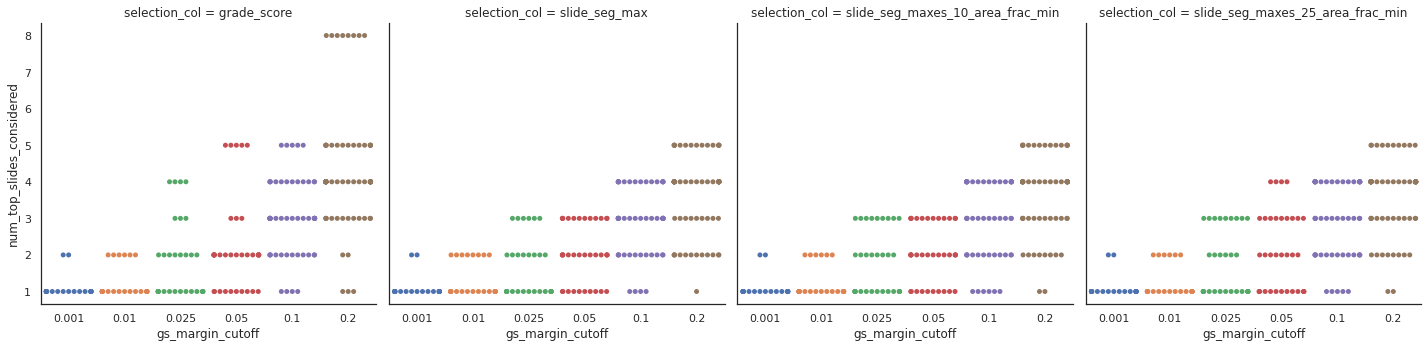

In [81]:
set_rc(12,12)
sns.catplot(col='selection_col', y='num_top_slides_considered', x='gs_margin_cutoff', kind='swarm', data=results,aspect=1)

In [82]:
results['nll'] = -np.log(results['prob_observation_based_on_top_slide'])

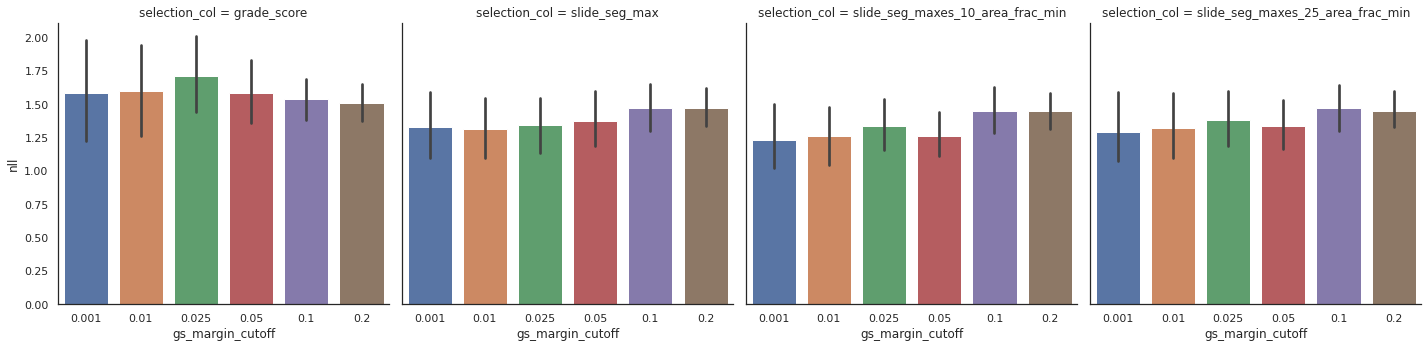

In [83]:
set_rc(12,12)
sns.catplot(col='selection_col', y='nll', x='gs_margin_cutoff', kind='bar', data=results, aspect=1)

In [84]:
comparison_agg = []
llrt_results = {}
tie_llrt_results = {}

for selection_col in selection_cols:
    print('\n =====================================')
    print(f'\n {selection_col}')
    prev_p = prev_results.loc[prev_results['selection_col'] == selection_col,'prob_observation_based_on_top_slide']
    prev_p.name = f'baseline_{selection_col}'

    agg = results.groupby(['selection_col','gs_margin_cutoff','case_num']).mean()
    for gs_margin_cutoff in gs_margin_cutoffs:
    # for gs_margin_cutoff in [0.05]:
        # print(gs_margin_cutoff)
        z = agg.loc[(selection_col, gs_margin_cutoff), 'prob_observation_based_on_top_slide']

        comparison = meta_results['data'][['betabinom_p']].join(z).join(prev_p)
        comparison_agg.append(comparison.transpose())
        # print(comparison.aggregate(['mean','median']).transpose())

        loglikelihoods = np.log(comparison).sum()
        # print('\n\n', loglikelihoods['prob_observation_based_on_top_slide'], '\n\n')
        for col in [prev_p.name, 'prob_observation_based_on_top_slide']:
            null_ll = loglikelihoods['betabinom_p']
            alt_ll = loglikelihoods[col]
            pval = llrt(alt_ll, null_ll, 1)
            # print(f'\n {col}: LLRT pval = {pval :.3f}' )  # I think d.f. = 1? since the only dimensionality increase is from observing the indicator of top slide? otherwise same dims for betabinomial params
            # print(f'Alt LL: {alt_ll :.3f}, Null LL: {null_ll :.3f} \n')
            
            context = 'proposed' if col == 'prob_observation_based_on_top_slide' else 'baseline'
            cutoff_flag = gs_margin_cutoff if context == 'proposed' else 0
            llrt_results[(cutoff_flag, context, selection_col)] = {'pval':pval, 'null_ll':null_ll, 'alt_ll':alt_ll}
            
        null_ll = loglikelihoods[prev_p.name]
        alt_ll = loglikelihoods['prob_observation_based_on_top_slide']
        pval = llrt(alt_ll, null_ll, 1)
        # print(f'Previous vs Proposed: LLRT pval = {pval :.3f}' )  # I think d.f. = 1? since the only dimensionality increase is from observing the indicator of top slide? otherwise same dims for betabinomial params
        # print(f'Alt LL: {alt_ll :.3f}, Null LL: {null_ll :.3f} \n')
        tie_llrt_results[(gs_margin_cutoff, selection_col)] = {'pval':pval, 'null_ll':null_ll, 'alt_ll':alt_ll}

    
    
#         sns.lmplot(x='betabinom_p', y=prev_p.name, data=comparison)
#         plt.plot(np.linspace(0,0.5, 10), np.linspace(0,0.5, 10), ls='--',c='r')
#         plt.title(gs_margin_cutoff)
#         plt.show()

    
#         sns.lmplot(x='betabinom_p', y='prob_observation_based_on_top_slide', data=comparison)
#         plt.plot(np.linspace(0,0.5, 10), np.linspace(0,0.5, 10), ls='--',c='r')
#         plt.title(gs_margin_cutoff)
#         plt.show()

#         sns.lmplot(x=prev_p.name, y='prob_observation_based_on_top_slide', data=comparison)
#         plt.plot(np.linspace(0,0.5, 10), np.linspace(0,0.5, 10), ls='--',c='r')
#         plt.title(gs_margin_cutoff)
#         plt.show()

comparison_agg = pd.concat(comparison_agg).drop_duplicates().transpose()



 grade_score


 slide_seg_max


 slide_seg_maxes_10_area_frac_min


 slide_seg_maxes_25_area_frac_min


In [85]:
llrt_results = pd.DataFrame(llrt_results).transpose()
llrt_results.index = llrt_results.index.set_names(['gs_margin_cutoff','context','selection_type'])
llrt_results = llrt_results.reset_index()
llrt_results['neg_log10_llrt_pval'] = -np.log10(llrt_results['pval'])

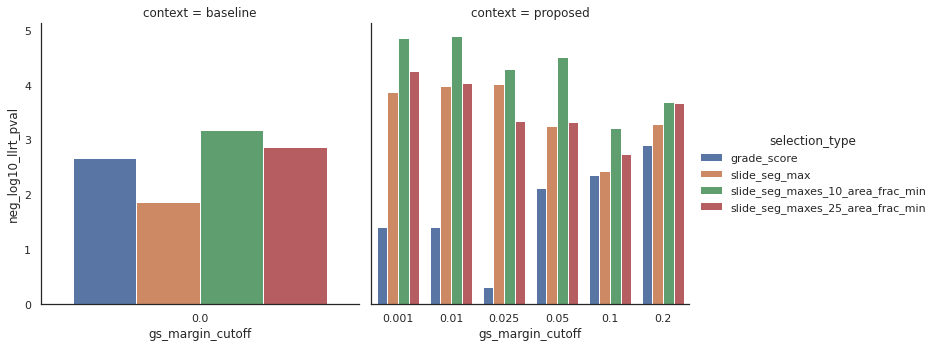

In [86]:
set_rc(12,12)
sns.catplot(x='gs_margin_cutoff', y='neg_log10_llrt_pval', col='context', hue='selection_type', data=llrt_results, kind='bar', sharex=False)

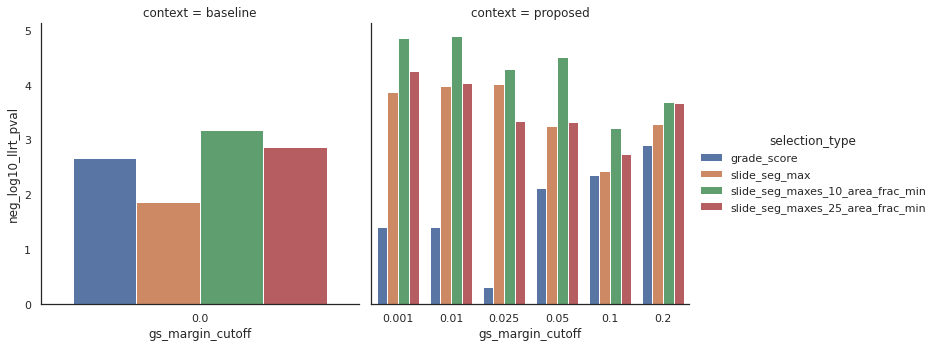

In [87]:
set_rc(12,12)
sns.catplot(x='gs_margin_cutoff', y='neg_log10_llrt_pval', col='context', hue='selection_type', data=llrt_results, kind='bar', sharex=False)

In [88]:
np.all(llrt_results.apply(lambda x: x['null_ll'] < x['alt_ll'], 1))

True

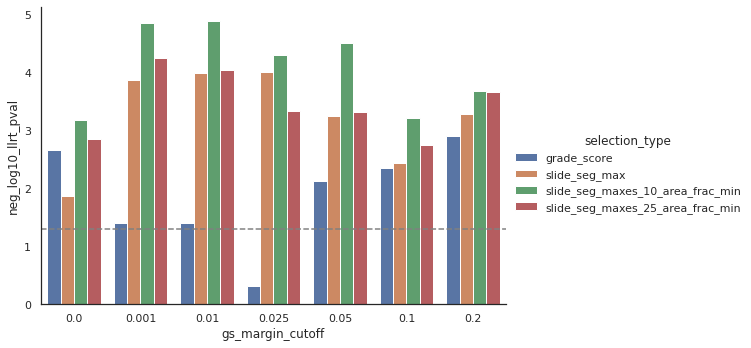

In [89]:
set_rc(12,12)
sns.catplot(x='gs_margin_cutoff', y='neg_log10_llrt_pval',hue='selection_type', data=llrt_results, kind='bar', sharex=False, aspect=1.5)
plt.axhline(-np.log10(0.05), ls='--', c='grey')

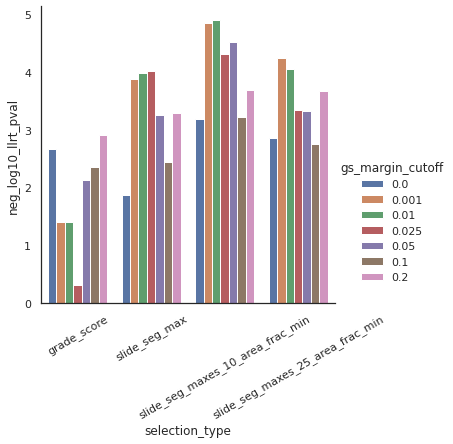

In [90]:
set_rc(12,12)
g = sns.catplot(hue='gs_margin_cutoff', y='neg_log10_llrt_pval',x='selection_type', data=llrt_results, kind='bar', sharex=False)
rotate_sns_labels(g)

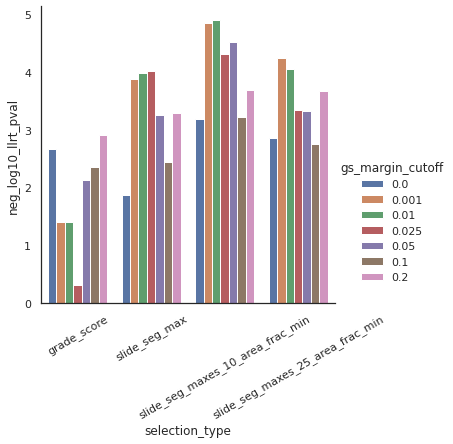

In [91]:
set_rc(12,12)
g = sns.catplot(hue='gs_margin_cutoff', y='neg_log10_llrt_pval',x='selection_type', data=llrt_results, kind='bar', sharex=False)
rotate_sns_labels(g)

In [92]:
llrt_results['Tie-Breaker Margin'] = llrt_results['gs_margin_cutoff']
llrt_results.loc[llrt_results['Tie-Breaker Margin'] == 0, 'Tie-Breaker Margin'] = 'None'

selection_type_map = {
    'grade_score':'Highest Avg. GS',
    'slide_seg_max':'Highest GS Seg.',
    'slide_seg_maxes_10_area_frac_min':'Highest GS Seg.\n (10%+ Slide Area)',
    'slide_seg_maxes_25_area_frac_min':'Highest GS Seg.\n (25%+ Slide Area)',

}

llrt_results['Selection Type'] = llrt_results['selection_type'].map(selection_type_map)

llrt_results['-log10(LLRT p-value)'] = llrt_results['neg_log10_llrt_pval']

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


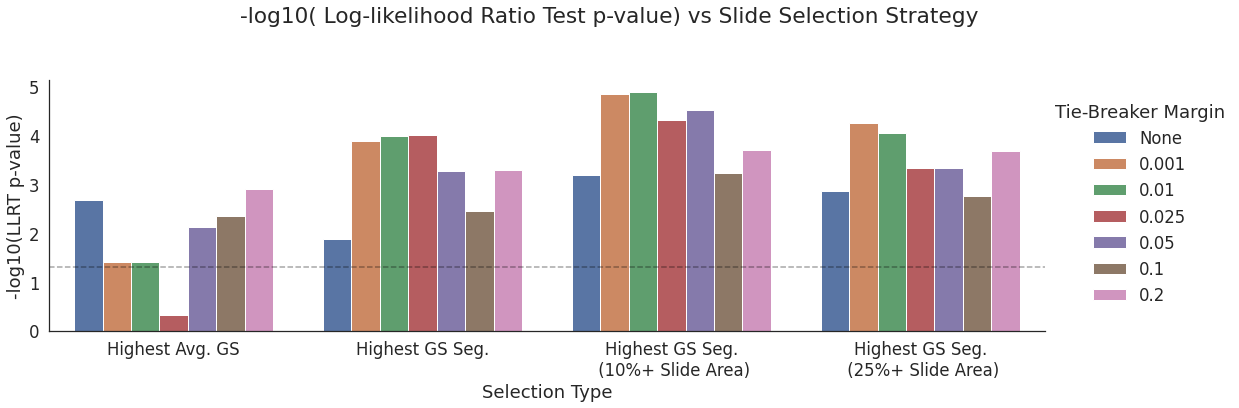

In [93]:
set_rc(12,12,1.5)

plot_kws = {
    'hue':'Tie-Breaker Margin',
    'x':'Selection Type',
    'y':'-log10(LLRT p-value)',
    'kind':'bar',
    'data':llrt_results,
    'aspect':3,
}
g = sns.catplot(**plot_kws)
plt.suptitle('-log10( Log-likelihood Ratio Test p-value) vs Slide Selection Strategy', y=1.15)
plt.axhline(-np.log10(0.05), ls='--', c='black', alpha=0.35)
plt.savefig('./multislide_figures/-log10( Log-likelihood Ratio Test p-value) vs Slide Selection Strategy.png', bbox_inches='tight')
# rotate_sns_labels(g)

In [94]:
llrt_results.sort_values(['pval']).head()

gs_margin_cutoff   context                    selection_type      pval  \
16             0.010  proposed  slide_seg_maxes_10_area_frac_min  0.000013   
15             0.001  proposed  slide_seg_maxes_10_area_frac_min  0.000014   
18             0.050  proposed  slide_seg_maxes_10_area_frac_min  0.000030   
17             0.025  proposed  slide_seg_maxes_10_area_frac_min  0.000050   
22             0.001  proposed  slide_seg_maxes_25_area_frac_min  0.000056   

      null_ll     alt_ll  neg_log10_llrt_pval Tie-Breaker Margin  \
16 -35.412957 -25.888341             4.894868               0.01   
15 -35.412957 -25.973649             4.856032              0.001   
18 -35.412957 -26.710671             4.519852               0.05   
17 -35.412957 -27.182429             4.303996              0.025   
22 -35.412957 -27.300796             4.249746              0.001   

                         Selection Type  -log10(LLRT p-value)  
16  Highest GS Seg.\n (10%+ Slide Area)              4.894868  
15  Highest GS Seg.\n (10%+ Slide Area)              4.856032  
18  Highest GS Seg.\n (10%+ Slide Area)              4.519852  
17  Highest GS Seg.\n (10%+ Slide Area)              4.303996  
22  Highest GS Seg.\n (25%+ Slide Area)              4.249746

In [95]:
tie_llrt_results = pd.DataFrame(tie_llrt_results).transpose()
tie_llrt_results.index = tie_llrt_results.index.set_names(['gs_margin_cutoff','selection_type'])
tie_llrt_results = tie_llrt_results.reset_index()
tie_llrt_results['neg_log10_llrt_pval'] = -np.log10(tie_llrt_results['pval'])

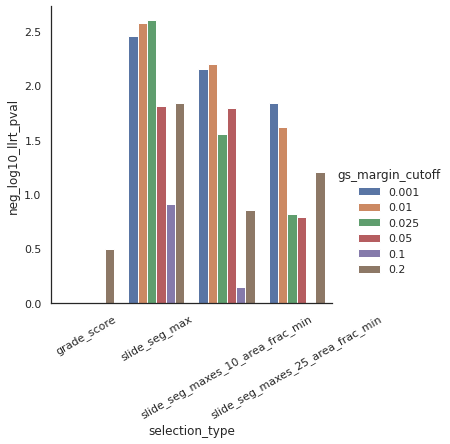

In [96]:
set_rc(12,12)
g = sns.catplot(hue='gs_margin_cutoff', y='neg_log10_llrt_pval',x='selection_type', data=tie_llrt_results, kind='bar', sharex=False)
rotate_sns_labels(g)

In [97]:
agg.groupby(['gs_margin_cutoff', 'selection_col',]).prob_observation_based_on_top_slide.describe().sort_values('mean')

count      mean       std  \
gs_margin_cutoff selection_col                                                 
0.025            grade_score                        21.0  0.246624  0.141616   
0.100            grade_score                        21.0  0.256789  0.122877   
                 slide_seg_max                      21.0  0.262422  0.127495   
0.050            grade_score                        21.0  0.265817  0.137645   
0.100            slide_seg_maxes_25_area_frac_min   21.0  0.267372  0.124041   
0.010            grade_score                        21.0  0.269430  0.148153   
0.001            grade_score                        21.0  0.269984  0.148729   
0.200            grade_score                        21.0  0.270894  0.123603   
                 slide_seg_max                      21.0  0.271041  0.113851   
0.100            slide_seg_maxes_10_area_frac_min   21.0  0.281792  0.129223   
0.200            slide_seg_maxes_25_area_frac_min   21.0  0.282006  0.118266   
                 slide_seg_maxes_10_area_frac_min   21.0  0.282482  0.118009   
0.050            slide_seg_maxes_25_area_frac_min   21.0  0.287200  0.130703   
0.025            slide_seg_maxes_25_area_frac_min   21.0  0.288319  0.132834   
0.050            slide_seg_max                      21.0  0.288462  0.134468   
0.010            slide_seg_max                      21.0  0.301488  0.129195   
0.001            slide_seg_max                      21.0  0.302201  0.133288   
0.025            slide_seg_max                      21.0  0.302668  0.129024   
0.010            slide_seg_maxes_25_area_frac_min   21.0  0.307274  0.133093   
0.025            slide_seg_maxes_10_area_frac_min   21.0  0.308928  0.121805   
0.001            slide_seg_maxes_25_area_frac_min   21.0  0.313154  0.132742   
0.050            slide_seg_maxes_10_area_frac_min   21.0  0.316879  0.125477   
0.010            slide_seg_maxes_10_area_frac_min   21.0  0.324880  0.120210   
0.001            slide_seg_maxes_10_area_frac_min   21.0  0.328998  0.128330   

                                                        min       25%  \
gs_margin_cutoff selection_col                                          
0.025            grade_score                       0.015075  0.116667   
0.100            grade_score                       0.042745  0.200000   
                 slide_seg_max                     0.042745  0.181916   
0.050            grade_score                       0.041896  0.142857   
0.100            slide_seg_maxes_25_area_frac_min  0.042745  0.200000   
0.010            grade_score                       0.015075  0.133333   
0.001            grade_score                       0.015075  0.120101   
0.200            grade_score                       0.042745  0.200000   
                 slide_seg_max                     0.093333  0.200000   
0.100            slide_seg_maxes_10_area_frac_min  0.042745  0.200000   
0.200            slide_seg_maxes_25_area_frac_min  0.100000  0.200000   
                 slide_seg_maxes_10_area_frac_min  0.100000  0.200000   
0.050            slide_seg_maxes_25_area_frac_min  0.042745  0.200000   
0.025            slide_seg_maxes_25_area_frac_min  0.042745  0.200000   
0.050            slide_seg_max                     0.042745  0.200000   
0.010            slide_seg_max                     0.042745  0.214201   
0.001            slide_seg_max                     0.042745  0.214201   
0.025            slide_seg_max                     0.042745  0.236937   
0.010            slide_seg_maxes_25_area_frac_min  0.042745  0.214201   
0.025            slide_seg_maxes_10_area_frac_min  0.042745  0.266667   
0.001            slide_seg_maxes_25_area_frac_min  0.042745  0.236937   
0.050            slide_seg_maxes_10_area_frac_min  0.042745  0.266667   
0.010            slide_seg_maxes_10_area_frac_min  0.042745  0.259096   
0.001            slide_seg_maxes_10_area_frac_min  0.042745  0.259096   

                                                        50%       75%  

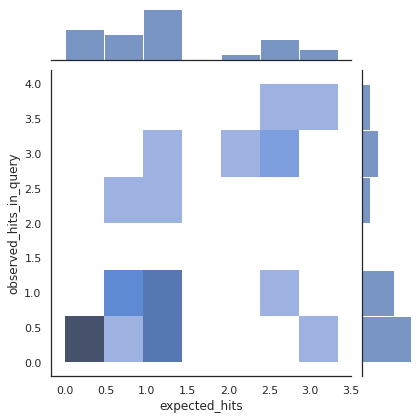

In [98]:
sns.jointplot(x='expected_hits',y='observed_hits_in_query', data=prev_results.loc[prev_results['selection_col'] == 'grade_score'], kind='hist')

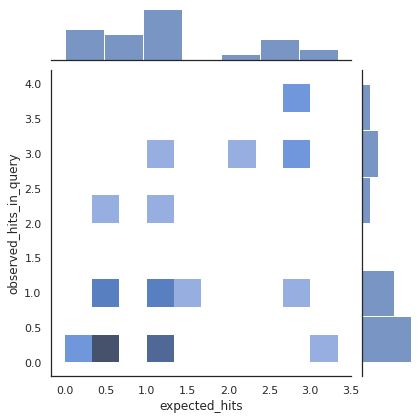

In [99]:
plot_bins = 10
sns.jointplot(x='expected_hits',y='observed_hits_in_query', data=prev_results.loc[prev_results['selection_col'] == 'grade_score'], kind='hist', bins=plot_bins)

In [100]:
# meta_results['data']
meta_results['data']['block_count']

case_num
24     3
11     3
18     3
17     3
22     3
3      4
6      4
29     4
21     4
23     4
25     4
28     4
15     4
27     4
19     5
12     5
26     5
16     5
9      6
10     9
7     10
Name: block_count, dtype: int64

Text(0, 0.5, 'Observed Het. Slides')

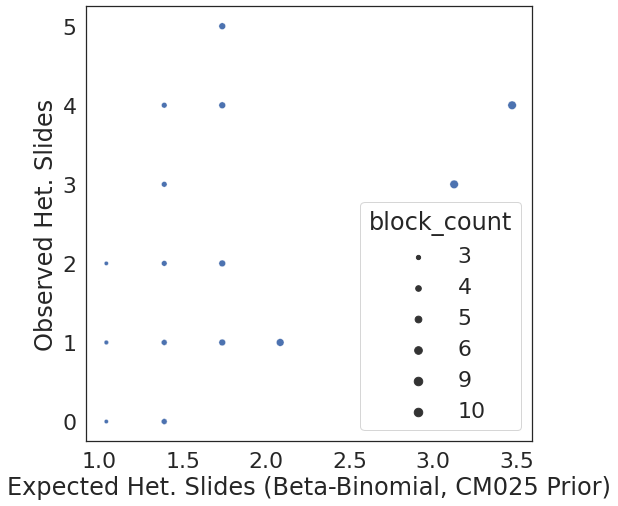

In [101]:
set_rc(8,8,2)
plot_bins = 'auto'

g = sns.scatterplot(x='betabinom_expect', y='het_count', data=meta_results['data'], size='block_count', size_norm=(3,7))
plt.xlabel('Expected Het. Slides (Beta-Binomial, CM025 Prior)')
plt.ylabel('Observed Het. Slides')

Text(0, 0.5, 'Observed Het. Slides')

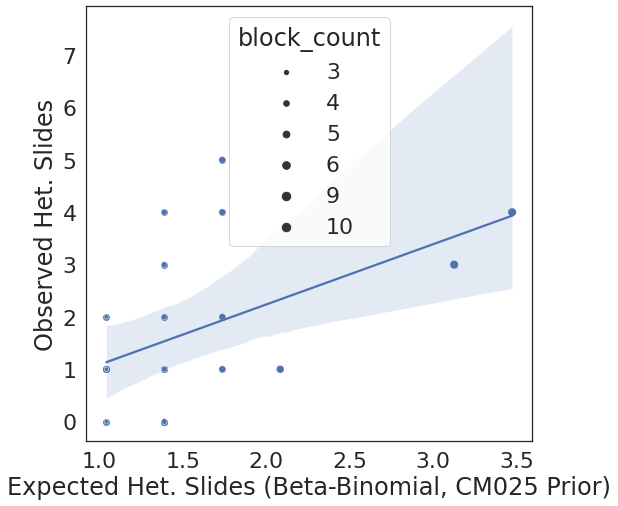

In [102]:
set_rc(8,8,2)
plot_bins = 'auto'
g = sns.regplot(x='betabinom_expect', y='het_count', data=meta_results['data'], )
g = sns.scatterplot(x='betabinom_expect', y='het_count', data=meta_results['data'], size='block_count', size_norm=(3,7))
plt.xlabel('Expected Het. Slides (Beta-Binomial, CM025 Prior)')
plt.ylabel('Observed Het. Slides')

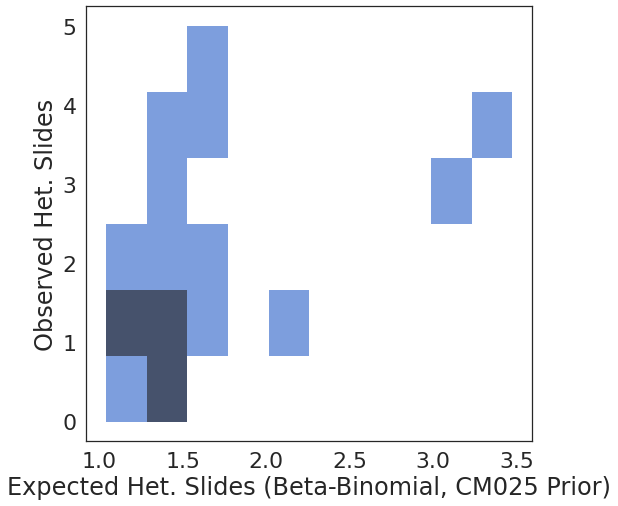

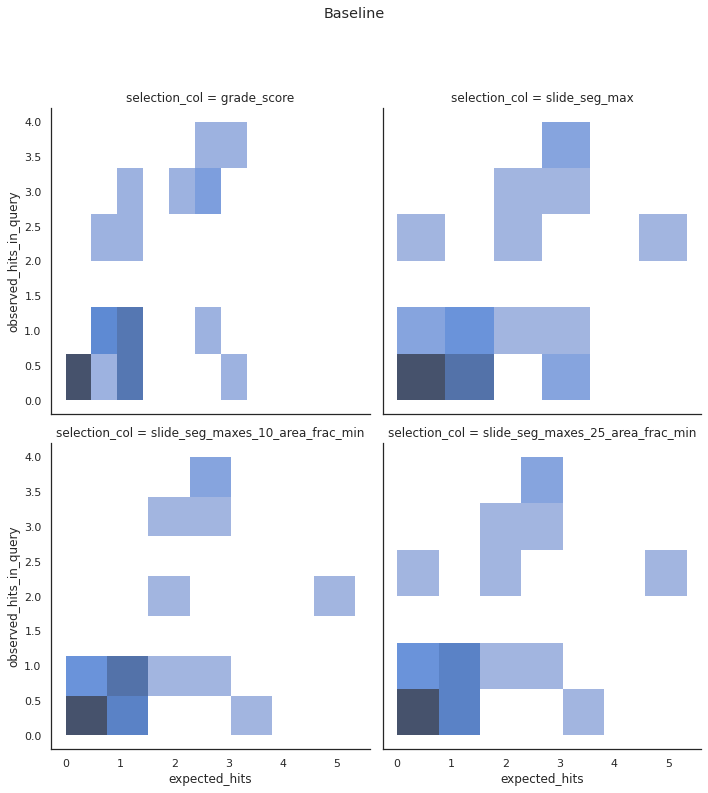

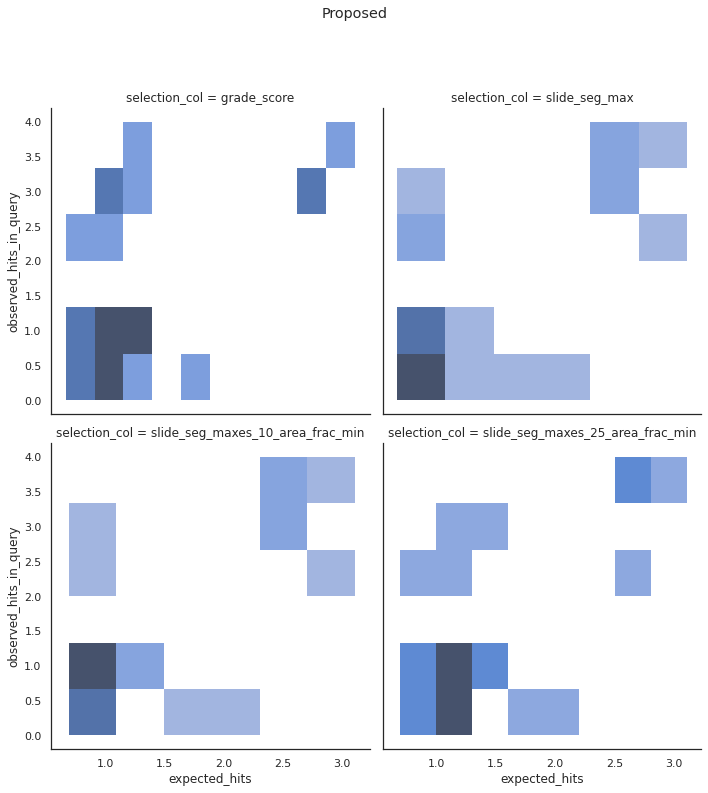

In [103]:
# plot_bins = list( np.arange(0,7, 0.5))
plot_bins = 'auto'


set_rc(8,8,2)
g = sns.histplot(x='betabinom_expect', y='het_count', data=meta_results['data'], bins=plot_bins)
plt.xlabel('Expected Het. Slides (Beta-Binomial, CM025 Prior)')
plt.ylabel('Observed Het. Slides')
plt.savefig('./multislide_figures/histplot_betabinomial_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()

set_rc(15,15)
g = sns.FacetGrid(col='selection_col', col_wrap = 2, data=prev_results, height=5, aspect=1)
g.map_dataframe(sns.histplot, x='expected_hits',y='observed_hits_in_query', bins=plot_bins)
plt.suptitle('Baseline', y=1.1)
plt.savefig('./multislide_figures/histplot_grid_reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()

set_rc(15,15)
g = sns.FacetGrid(col='selection_col', col_wrap = 2, data=results.loc[results['gs_margin_cutoff'] ==0.010], height=5)
g.map_dataframe(sns.histplot, x='expected_hits',y='observed_hits_in_query', bins=plot_bins)
plt.suptitle('Proposed', y=1.1)
plt.savefig('./multislide_figures/histplot_grid_margin_window_reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()

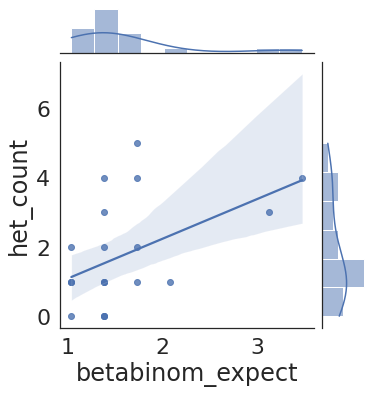

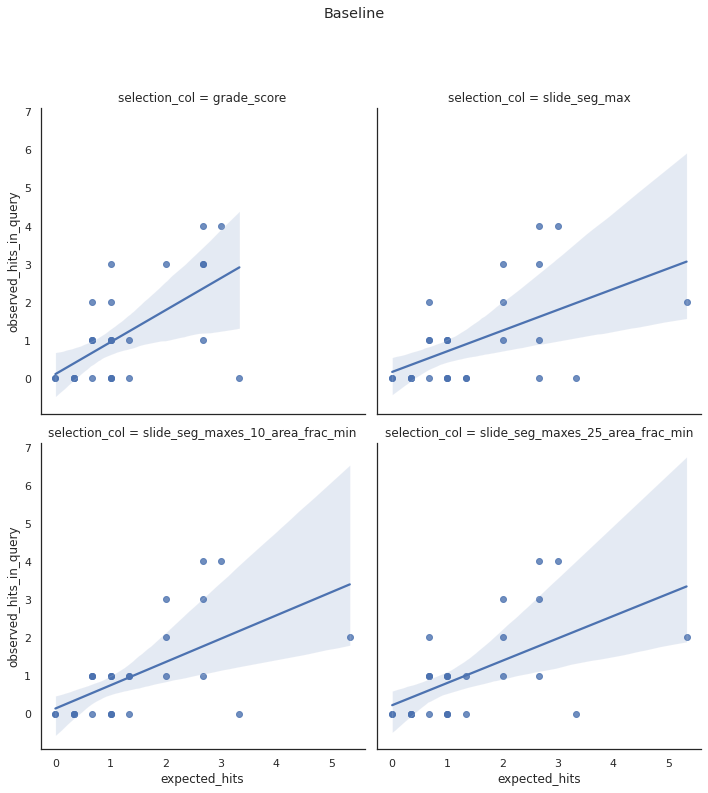

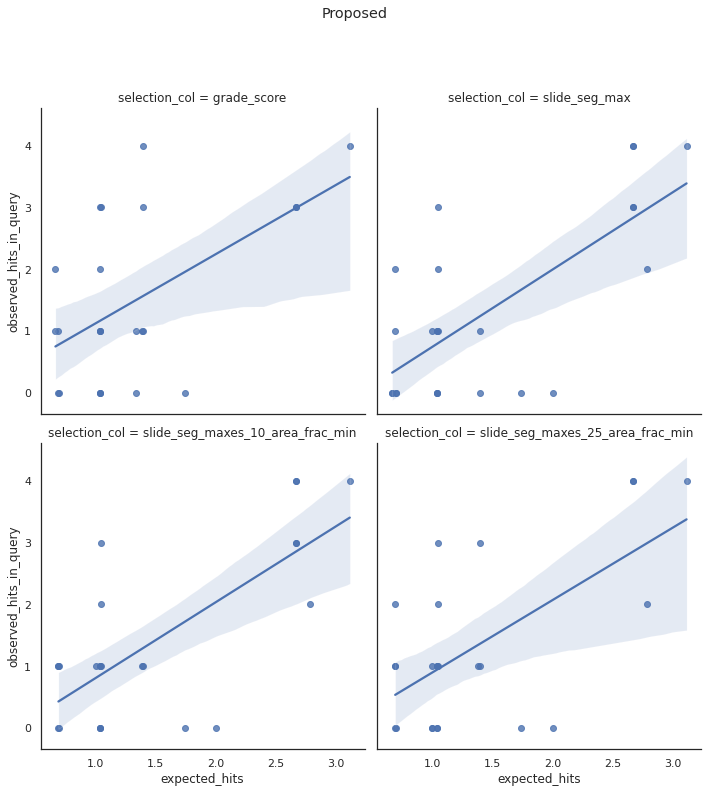

In [104]:
set_rc(8,8,2)
g = sns.jointplot(x='betabinom_expect', y='het_count', data=meta_results['data'], kind='reg')
plt.xlabel('Expected Het. Slides (Beta-Binomial, CM025 Prior)')
plt.ylabel('Observed Het. Slides')
plt.savefig('./multislide_figures/regplot_betabinomial_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()

set_rc(15,15)
plot_bins = 'auto'
g = sns.FacetGrid(col='selection_col', col_wrap = 2, data=prev_results, height=5, aspect=1)
g.map_dataframe(sns.regplot, x='expected_hits',y='observed_hits_in_query')
plt.suptitle('Baseline', y=1.1)
plt.savefig('./multislide_figures/regplot_grid_reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()

set_rc(15,15)
g = sns.FacetGrid(col='selection_col', col_wrap = 2, data=results.loc[results['gs_margin_cutoff'] ==0.010], height=5)
g.map_dataframe(sns.regplot, x='expected_hits',y='observed_hits_in_query')
plt.suptitle('Proposed', y=1.1)
plt.savefig('./multislide_figures/regplot_grid_margin_window_reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()

In [105]:
selection_type_map = {
    'grade_score':'Highest Avg. GS',
    'slide_seg_max':'Highest GS Seg.',
    'slide_seg_maxes_10_area_frac_min':'Highest GS Seg.\n (10%+ Slide Area)',
    'slide_seg_maxes_25_area_frac_min':'Highest GS Seg.\n (25%+ Slide Area)',

}


for df in [prev_results, results]:
    
    # df['Tie-Breaker Margin'] = df['gs_margin_cutoff']
    # df.loc[df['Tie-Breaker Margin'] == 0, 'Tie-Breaker Margin'] = 'None'
    df['Selection Type'] = df['selection_col'].map(selection_type_map)
    df['Expected Microhet. Cases'] = df['expected_hits'] 
    df['Observed Microhet. Cases'] = df['observed_hits_in_query']

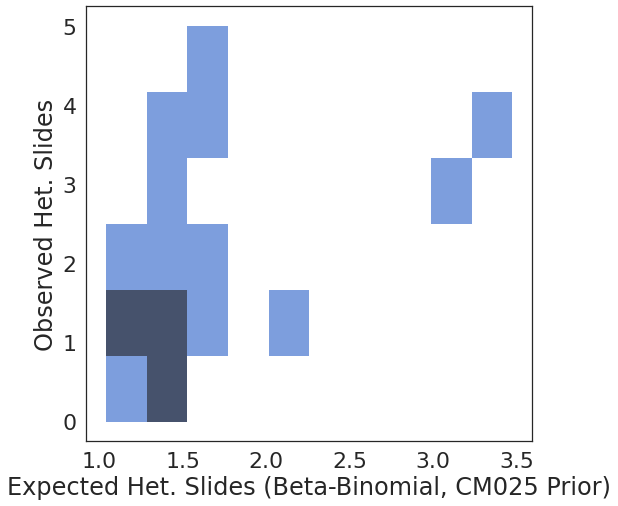

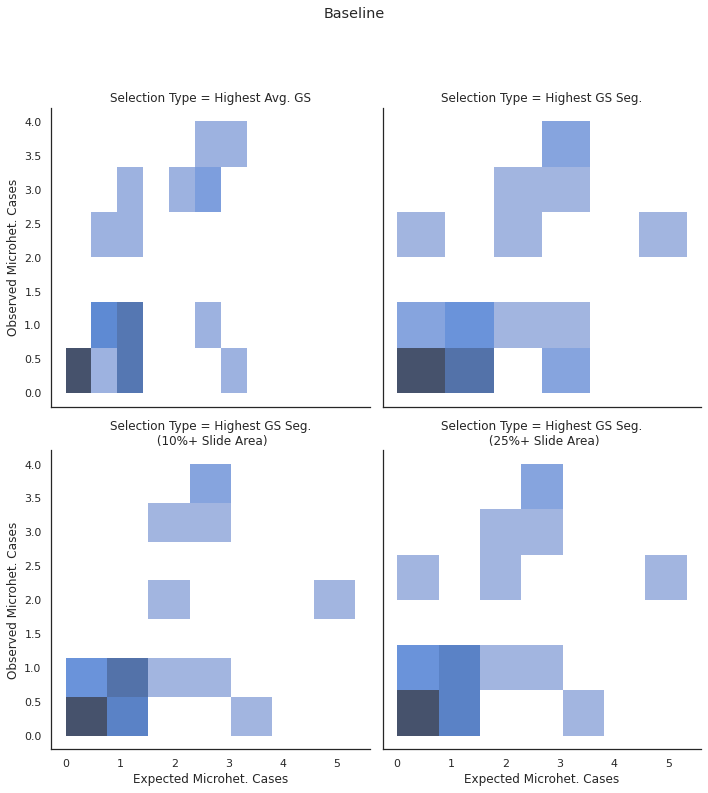

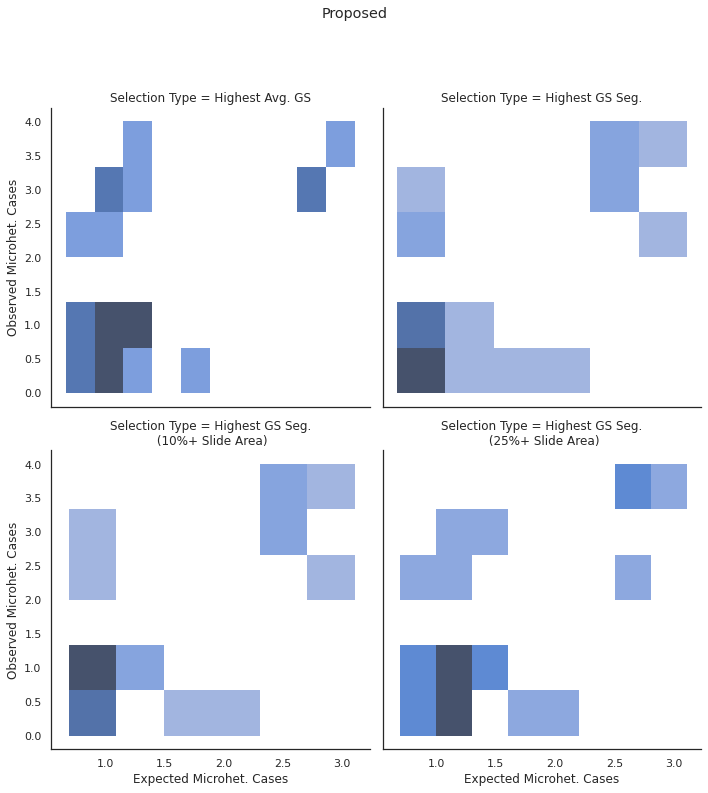

In [106]:
# plot_bins = list( np.arange(0,7, 0.5))
plot_bins = 'auto'


set_rc(8,8,2)
g = sns.histplot(x='betabinom_expect', y='het_count', data=meta_results['data'], bins=plot_bins)
plt.xlabel('Expected Het. Slides (Beta-Binomial, CM025 Prior)')
plt.ylabel('Observed Het. Slides')
plt.savefig('./multislide_figures/histplot_betabinomial_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()


col = 'Selection Type'
x = 'Expected Microhet. Cases'
y = 'Observed Microhet. Cases'
set_rc(15,15)
g = sns.FacetGrid(col=col, col_wrap = 2, data=prev_results, height=5, aspect=1)
g.map_dataframe(sns.histplot, x=x,y=y, bins=plot_bins)
plt.suptitle('Baseline', y=1.1)
plt.savefig('./multislide_figures/histplot_grid_reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()

set_rc(15,15)
g = sns.FacetGrid(col=col, col_wrap = 2, data=results.loc[results['gs_margin_cutoff'] ==0.010], height=5)
g.map_dataframe(sns.histplot, x=x,y=y, bins=plot_bins)
plt.suptitle('Proposed', y=1.1)
plt.savefig('./multislide_figures/histplot_grid_margin_window_reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()

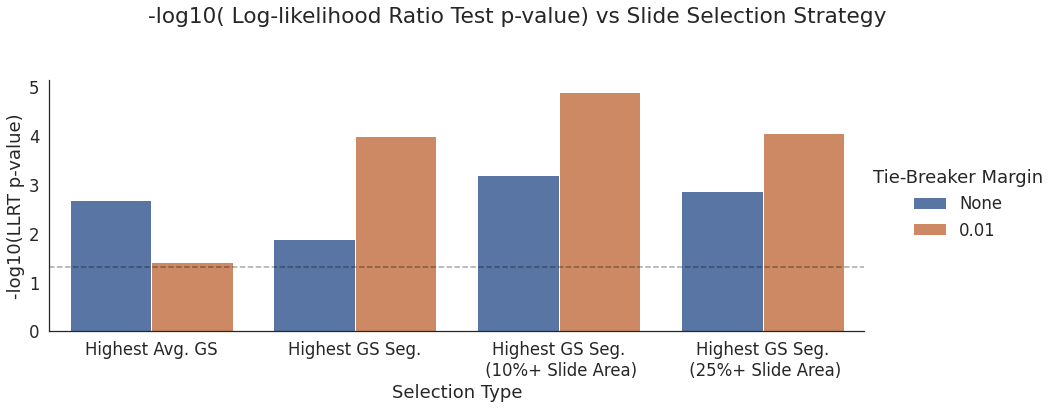

In [107]:
set_rc(12,12,1.5)

plot_kws = {
    'hue':'Tie-Breaker Margin',
    'hue_order':['None',0.01],
    'x':'Selection Type',
    'y':'-log10(LLRT p-value)',
    'kind':'bar',
    'data':llrt_results,
    'aspect':2.5,
}
g = sns.catplot(**plot_kws)
plt.suptitle('-log10( Log-likelihood Ratio Test p-value) vs Slide Selection Strategy', y=1.15)
plt.axhline(-np.log10(0.05), ls='--', c='black', alpha=0.35)
plt.savefig('./multislide_figures/-log10( Log-likelihood Ratio Test p-value) vs Slide Selection Strategy [subset thresh].png', bbox_inches='tight')
# rotate_sns_labels(g)

In [108]:
results['Selection Type'].unique()

array(['Highest Avg. GS', 'Highest GS Seg.',
       'Highest GS Seg.\n (10%+ Slide Area)',
       'Highest GS Seg.\n (25%+ Slide Area)'], dtype=object)

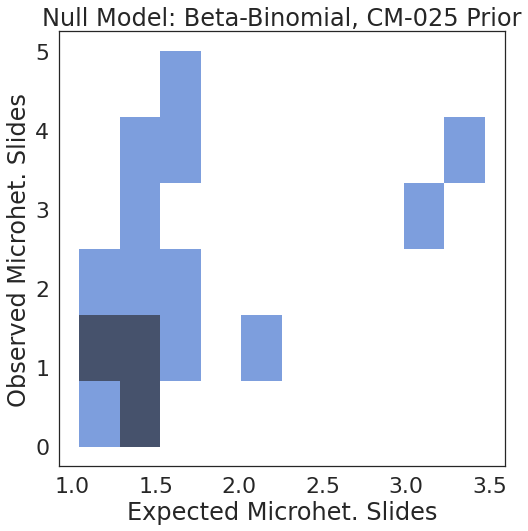

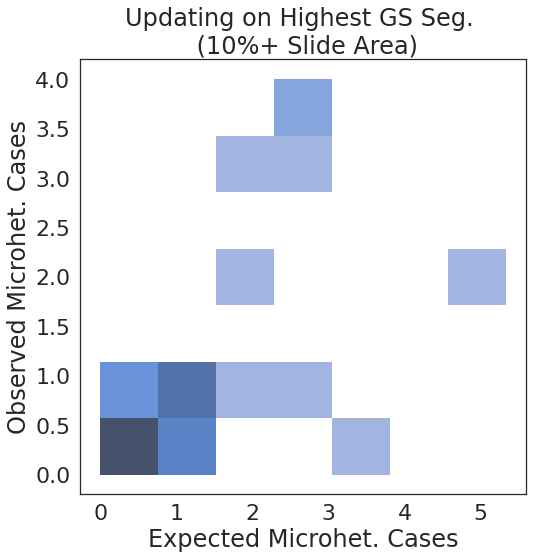

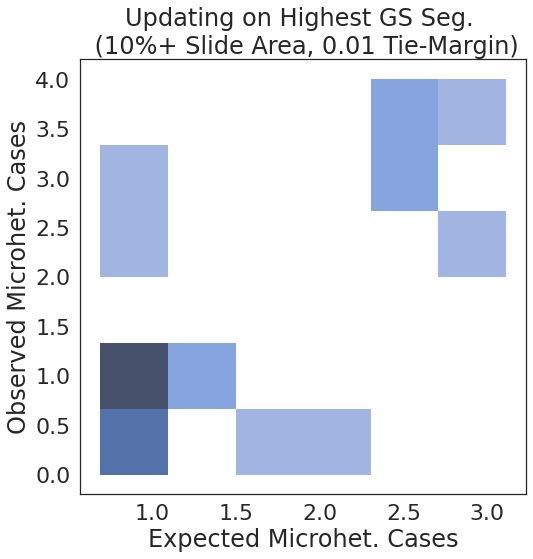

In [109]:
# plot_bins = list( np.arange(0,7, 0.5))
plot_bins = 'auto'


set_rc(8,8,2)
g = sns.histplot(x='betabinom_expect', y='het_count', data=meta_results['data'], bins=plot_bins)
plt.xlabel('Expected Microhet. Slides')
plt.ylabel('Observed Microhet. Slides')
plt.title('Null Model: Beta-Binomial, CM-025 Prior')
plt.savefig('./multislide_figures/histplot_betabinomial_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()


col = 'Selection Type'
x = 'Expected Microhet. Cases'
y = 'Observed Microhet. Cases'
plot_df = prev_results.loc[prev_results['Selection Type'] == 'Highest GS Seg.\n (10%+ Slide Area)']
set_rc(8,8,2)
sns.histplot()
plt.title('Updating on Highest GS Seg. \n (10%+ Slide Area)')
g = sns.histplot(x=x, y=y, data=plot_df, bins=plot_bins)
plt.savefig('./multislide_figures/histplot_single_top_perf__reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')

plt.show()

col = 'Selection Type'
x = 'Expected Microhet. Cases'
y = 'Observed Microhet. Cases'
plot_df = results.loc[results['gs_margin_cutoff'] ==0.010]
plot_df = plot_df.loc[plot_df['Selection Type'] == 'Highest GS Seg.\n (10%+ Slide Area)']

set_rc(8,8,2)
sns.histplot()
plt.title('Updating on Highest GS Seg. \n (10%+ Slide Area, 0.01 Tie-Margin)')
g = sns.histplot(x=x, y=y, data=plot_df, bins=plot_bins)
plt.savefig('./multislide_figures/histplot_single_top_perf__margin_window_reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
plt.show()

# g = sns.FacetGrid(col=col, col_wrap = 2, data=prev_results, height=5, aspect=1)
# g.map_dataframe(sns.histplot, x=x,y=y, bins=plot_bins)
# plt.suptitle('Baseline', y=1.1)
# plt.savefig('./multislide_figures/histplot_grid_reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
# plt.show()

# set_rc(15,15)
# g = sns.FacetGrid(col=col, col_wrap = 2, data=results.loc[results['gs_margin_cutoff'] ==0.010], height=5)
# g.map_dataframe(sns.histplot, x=x,y=y, bins=plot_bins)
# plt.suptitle('Proposed', y=1.1)
# plt.savefig('./multislide_figures/histplot_grid_margin_window_reference_single_slide_cm025_prior_expected_vs_observed_het_counts.png', bbox_inches='tight')
# plt.show()

### Bayes Factor when not doing tie-breaker

In [110]:
llrt_results['loglik_diff'] = llrt_results['alt_ll'] - llrt_results['null_ll']

In [111]:
llrt_results['bf'] = llrt_results['loglik_diff'].apply(np.exp)

In [112]:
llrt_results.loc[llrt_results['gs_margin_cutoff'].isin([0,])]['bf'].describe()

count      4.000000
mean     159.160434
std      132.417936
min       20.988189
25%       89.199804
50%      139.921261
75%      209.881891
max      335.811025
Name: bf, dtype: float64

In [113]:
llrt_results.loc[llrt_results['gs_margin_cutoff'].isin([0,])]['bf']

0     111.937008
7      20.988189
14    335.811025
21    167.905513
Name: bf, dtype: float64

In [114]:
# llrt_results

In [115]:
llrt_results.loc[llrt_results['gs_margin_cutoff'].isin([0,])].set_index('selection_type')['loglik_diff']

selection_type
grade_score                         4.717936
slide_seg_max                       3.043960
slide_seg_maxes_10_area_frac_min    5.816549
slide_seg_maxes_25_area_frac_min    5.123401
Name: loglik_diff, dtype: float64

In [116]:
llrt_results['bf'].describe()

count       28.000000
mean      1857.986345
std       3483.354012
min          1.273575
25%        101.186116
50%        402.872871
75%       1910.724193
max      13692.679861
Name: bf, dtype: float64

In [117]:
llrt_results['loglik_diff']

0     4.717936
1     2.117715
2     2.127349
3     0.241828
4     3.567085
5     4.045088
6     5.208994
7     3.043960
8     7.300719
9     7.540316
10    7.598711
11    5.967825
12    4.233141
13    6.028497
14    5.816549
15    9.439308
16    9.524617
17    8.230528
18    8.702287
19    5.884910
20    6.898674
21    5.123401
22    8.112161
23    7.671143
24    6.141068
25    6.105515
26    4.885425
27    6.853554
Name: loglik_diff, dtype: float64

In [118]:
bf_str = '[supp] [non tiebreaker bayesfactor] log10(bayes factor)'
scattered_results[bf_str] = llrt_results.loc[llrt_results['gs_margin_cutoff'].isin([0,])].set_index('selection_type')['loglik_diff'].to_dict

In [119]:
tb_str = '[supp]  tiebreaker 0.01 llrt] neg_log10_llrt_pval'
scattered_results[tb_str] = llrt_results.loc[llrt_results['gs_margin_cutoff'].isin([0.01,])].set_index('selection_type')['neg_log10_llrt_pval'].to_dict()

In [120]:
scattered_results

{'[supp] [pearsonrho, pval] omitting_homog_reg_case_mh_freq_vs_fhs_max_3plus': (0.7373383101356706,
  0.0007313338566483678),
 '[supp] [pearsonrho, pval] omitting_homog_hue_mark_case_mh_freq_vs_fhs_max_3plus': (0.7373383101356706,
  0.0007313338566483678),
 '[supp] [pearsonrho, pval] omitting_homog_reg_case_mh_freq_vs_fhs_mean_3plus': (0.30200131658565577,
  0.2387571412385807),
 '[supp] [pearsonrho, pval] omitting_homog_hue_mark_case_mh_freq_vs_fhs_mean_3plus': (0.30200131658565577,
  0.2387571412385807),
 '[supp] [pearsonrho, pval] omitting_homog_reg_case_mh_freq_vs_ths_max_3plus': (0.33503309718372176,
  0.18866514885512004),
 '[supp] [pearsonrho, pval] omitting_homog_hue_mark_case_mh_freq_vs_ths_max_3plus': (0.33503309718372176,
  0.18866514885512004),
 '[supp] [pearsonrho, pval] omitting_homog_reg_case_mh_freq_vs_ths_mean_3plus': (-0.08600483900225388,
  0.7427563115696139),
 '[supp] [pearsonrho, pval] omitting_homog_hue_mark_case_mh_freq_vs_ths_mean_3plus': (-0.08600483900225388,

In [121]:
10**-1.4073578623814498

0.03914192113959089

In [122]:
10**-4.894868262723732

1.273889439309966e-05

In [123]:
0.000731

0.000731

In [124]:
7.31e-4

0.000731

In [125]:
llrt_results.to_csv('./reference_slide_comparison_llrt_results.csv')

In [126]:
def flatten_results(x):
    if type(x) == dict:
        return x
    elif type(x) == pd.Series:
        return x.to_dict()
    else:
        return {'val':x}

In [127]:
flattened_results = {k:flatten_results(v) for k,v in scattered_results.items()}

In [128]:
pd.Series(flattened_results).to_csv('./intracase_variation_pval_result_agg.csv')